In [1]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

from fsec.anchoring import BKHK, compute_anchor_neighbors
from fsec.ensemble import generate_base_clusterings, build_bipartite_graph, consensus_clustering
from fsec.plotting import *
from fsec.similarity import compute_sample_anchor_similarities
from fsec.spectral import compute_svd
from fsec.utils import clustering_accuracy, generate_2d_datasets

%matplotlib inline
sns.set(style="whitegrid")


In [2]:
def apply_fsec_pipeline(dataset_name, dataset, algo_params, num_anchors=50, K_prime=None, K=5, n_components=2, num_clusters_list=[2, 3, 4, 5], visualize=True):
    """
    Apply the FSEC pipeline to a given dataset and visualize the results.
    
    Parameters:
    - ...
    - K_prime: Number of anchor neighbors to consider. If None, set to 10*K.
    - ...
    """
    X, y = dataset
    print(f"\nProcessing Dataset: {dataset_name}")
    
    # Extract the expected number of clusters
    final_n_clusters = algo_params.get('n_clusters', 10)  # Default to 10 if not specified
    
    # Normalize dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Dimensionality Reduction for visualization (already 2D, so PCA is optional)
    if X_scaled.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
    else:
        X_pca = X_scaled  # If already 2D
    
    if visualize:
        plot_data(X_pca, y, title=f"{dataset_name} - Data Distribution (PCA Reduced)", xlabel="PCA Component 1", ylabel="PCA Component 2")
    
    # FSEC Steps
    # 1. Anchor Selection
    anchors, anchor_assignments = BKHK(X_scaled, num_anchors)
    
    # 2. Reduce Anchors for Visualization
    if X_scaled.shape[1] > 2:
        anchors_pca = pca.transform(anchors)
    else:
        anchors_pca = anchors  # If already 2D
    
    if visualize:
        plot_anchors(X_pca, anchors_pca, title=f"{dataset_name} - Selected Anchors (PCA Reduced)")
    
    # 3. Compute Anchor Neighbors
    if K_prime is None:
        K_prime = 10 * K
    K_prime = min(K_prime, num_anchors - 1)
    anchor_neighbors = compute_anchor_neighbors(anchors, K_prime)
    
    if visualize:
        plot_anchor_neighbors(anchors_pca, anchor_neighbors, 
                              title=f"{dataset_name} - Anchor Neighbors (PCA Reduced)")
    
    # 4. Compute Sample-Anchor Similarities
    W = compute_sample_anchor_similarities(X_scaled, anchors, anchor_assignments, anchor_neighbors, K)
    
    if visualize:
        plot_similarity_matrix(W, subset=100, title=f"{dataset_name} - Similarity Matrix Subset")
    
    # 5. Compute SVD
    U = compute_svd(W, n_components)
    
    # 6. Spectral Embedding with t-SNE for Visualization
    U_embedded = U  # Since n_components=2, U is already 2D
    
    if visualize and y is not None:
        plot_spectral_embedding_direct(U_embedded, y, title=f"{dataset_name} - Spectral Embedding with True Labels")
    elif visualize:
        plot_spectral_embedding_direct(U_embedded, None, title=f"{dataset_name} - Spectral Embedding")
    
    # 7. Generate Base Clusterings
    base_clusterings = generate_base_clusterings(U, num_clusters_list)
    
    if visualize:
        # Use U directly for visualization
        plot_base_clusterings_direct(U, base_clusterings, num_visualize=3, num_clusters_list=num_clusters_list, title_prefix=f"{dataset_name} - Base Clustering")
    
    # 8. Build Bipartite Graph
    H = build_bipartite_graph(base_clusterings)
    
    if visualize:
        plot_degree_distribution(H, title=f"{dataset_name} - Degree Distribution of Clusters in Bipartite Graph")
    
    # 9. Consensus Clustering
    final_labels = consensus_clustering(H, n_clusters=final_n_clusters)
    
    # 10. Final Visualization with t-SNE
    if visualize:
        plot_final_clustering_direct(U_embedded, y, final_labels, title_true=f"{dataset_name} - True Labels", title_final=f"{dataset_name} - Final Clustering Results")
    
    # 11. Final Visualization with PCA (Side-by-Side Comparison)
    if visualize:
        plot_final_clustering_pca(X_pca, y, final_labels, title_true=f"{dataset_name} - True Labels", title_final=f"{dataset_name} - Final Clustering Results")
    
    # 12. Evaluation Metrics
    metrics = {}
    if y is not None:
        nmi = normalized_mutual_info_score(y, final_labels)
        ari = adjusted_rand_score(y, final_labels)
        acc = clustering_accuracy(y, final_labels)
        
        print(f"Evaluation Metrics for {dataset_name}:")
        print(f"  Normalized Mutual Information (NMI): {nmi:.4f}")
        print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
        print(f"  Clustering Accuracy (ACC): {acc:.4f}")
        
        metrics = {
            'nmi': nmi,
            'ari': ari,
            'acc': acc,
            'final_labels': final_labels,
            'U_embedded': U_embedded
        }
    else:
        print(f"No true labels available for {dataset_name}. Skipping evaluation metrics.")
        metrics = {
            'nmi': None,
            'ari': None,
            'acc': None,
            'final_labels': final_labels,
            'U_embedded': U_embedded
        }
    
    return metrics



Processing Dataset: Noisy Circles


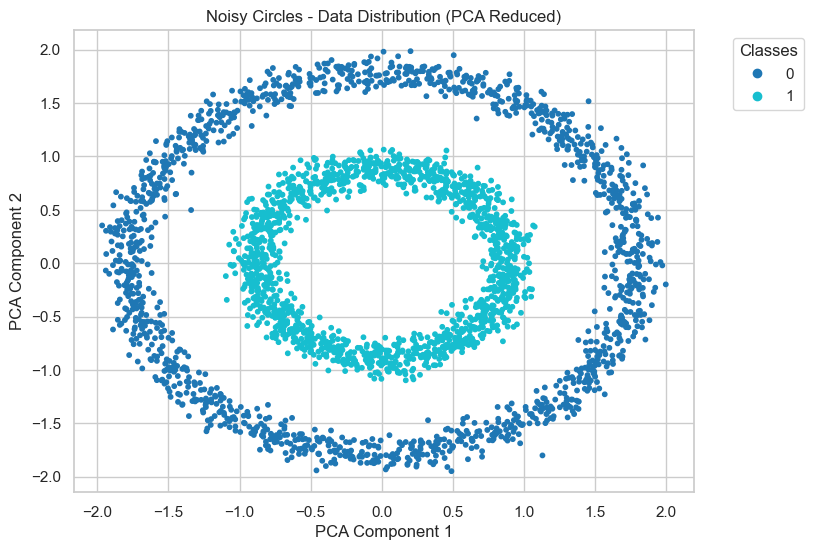

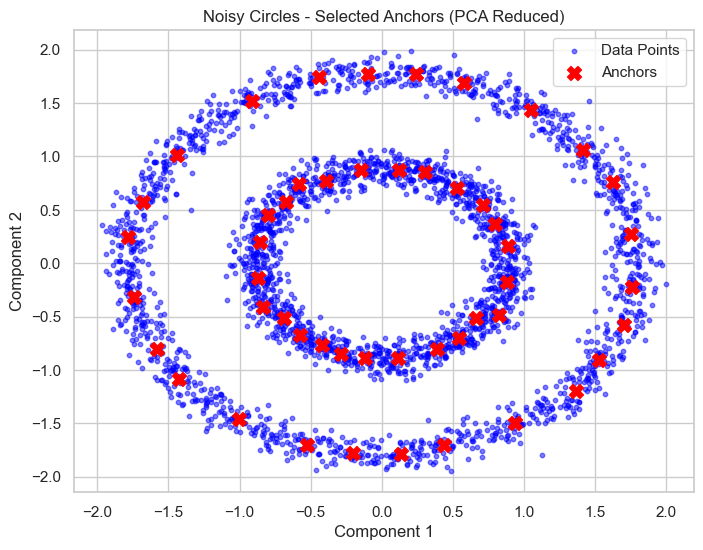

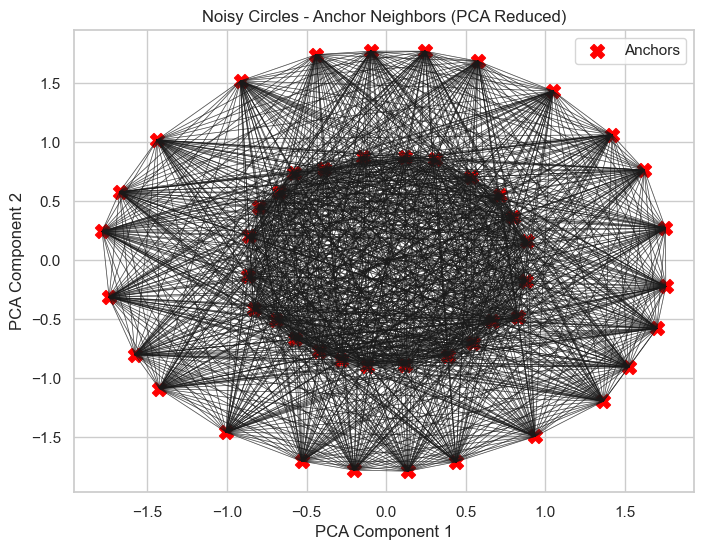

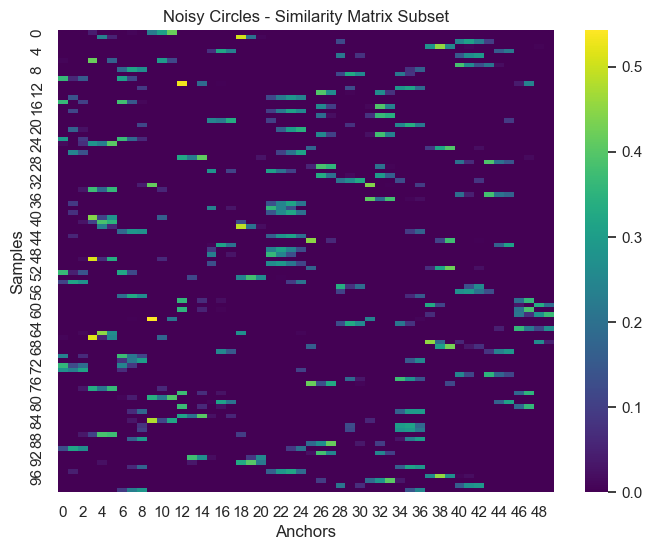

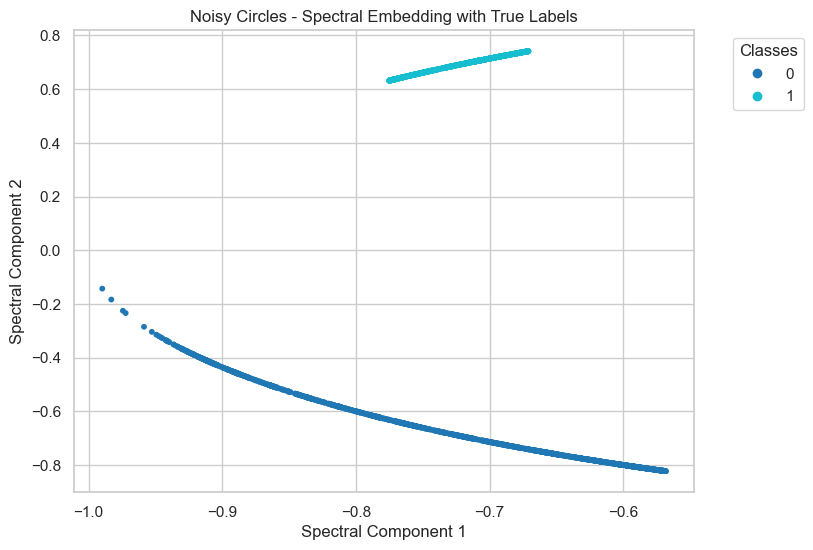

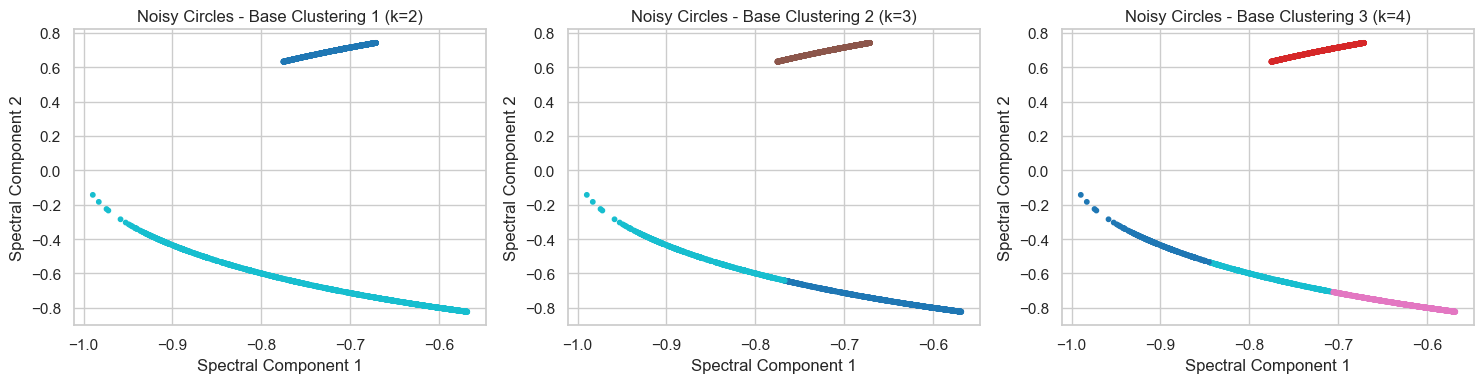

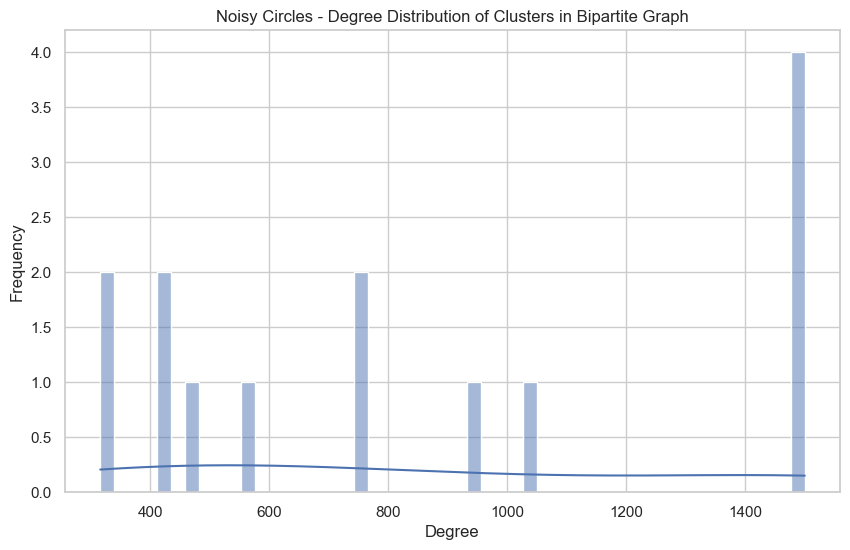

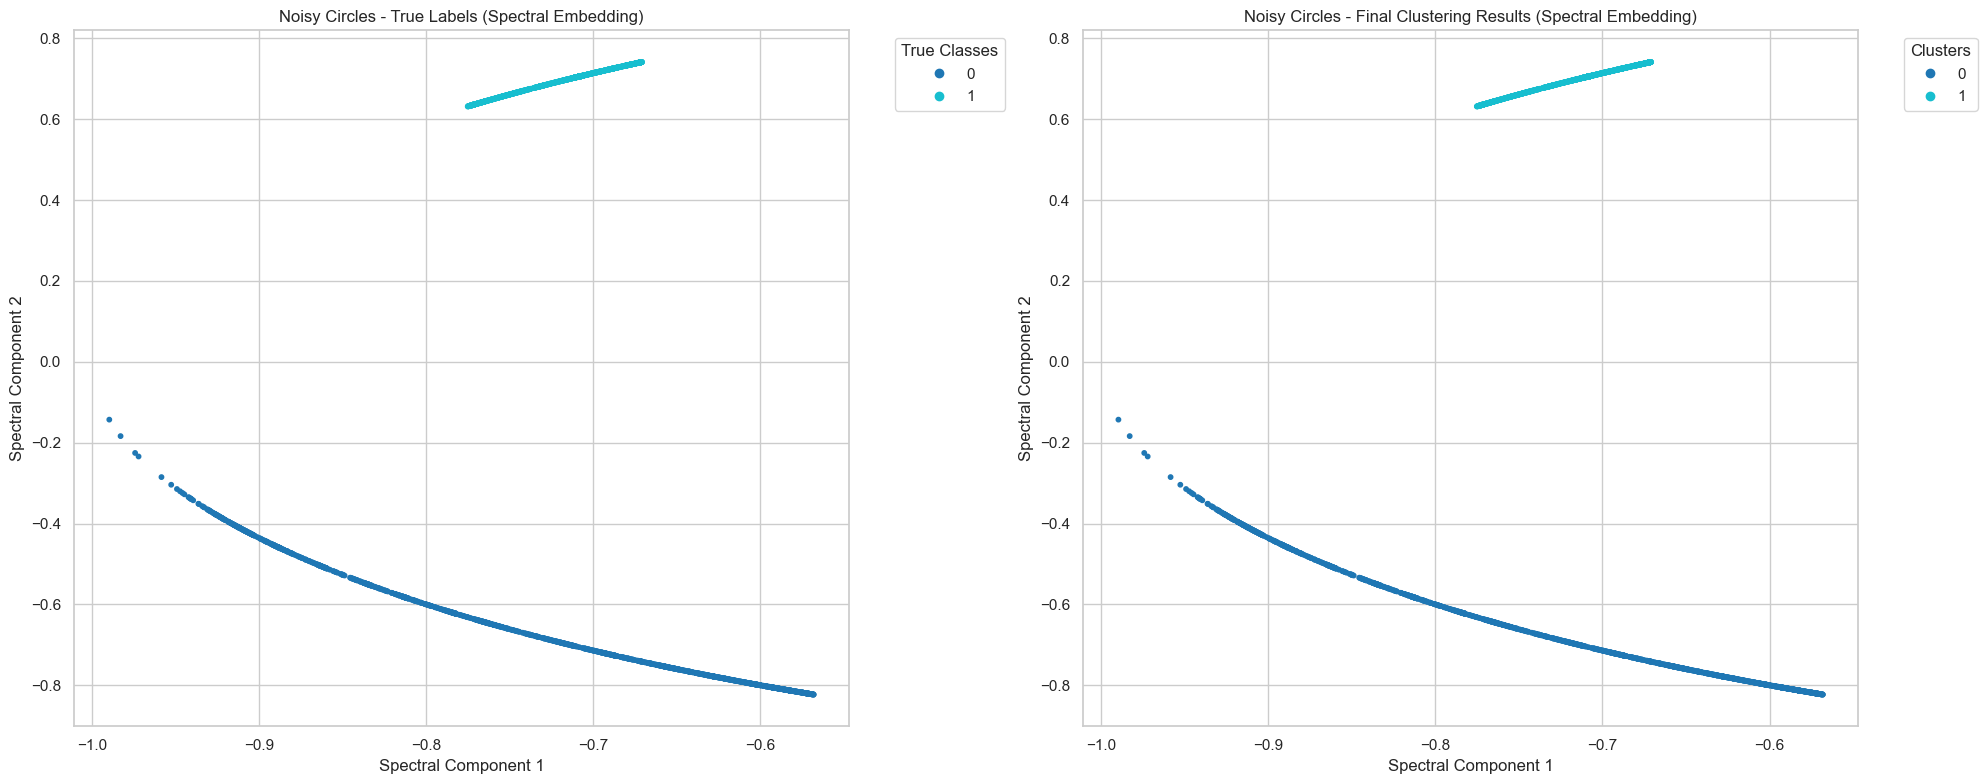

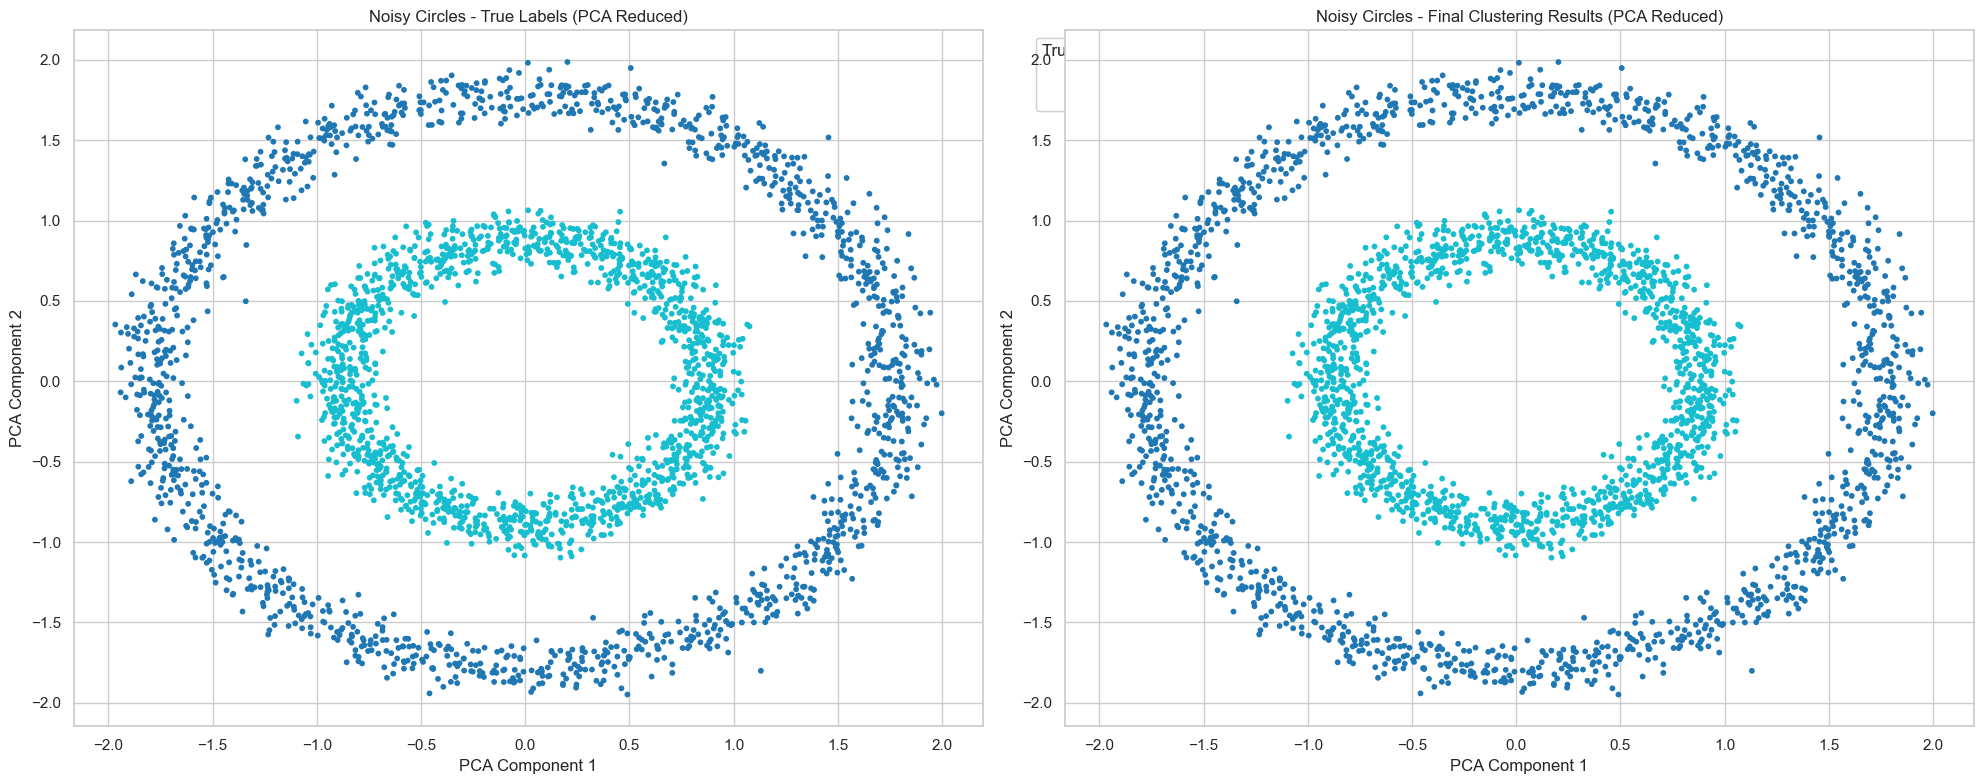

Evaluation Metrics for Noisy Circles:
  Normalized Mutual Information (NMI): 1.0000
  Adjusted Rand Index (ARI): 1.0000
  Clustering Accuracy (ACC): 1.0000

Processing Dataset: Noisy Moons


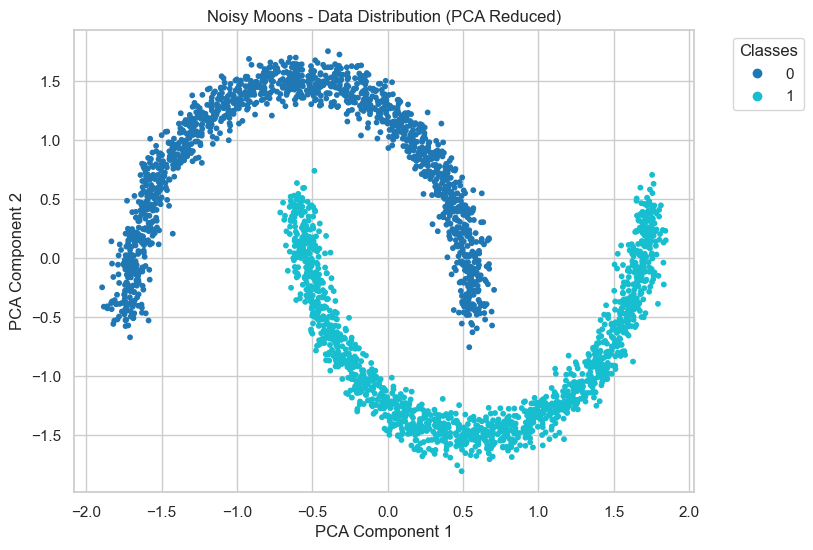

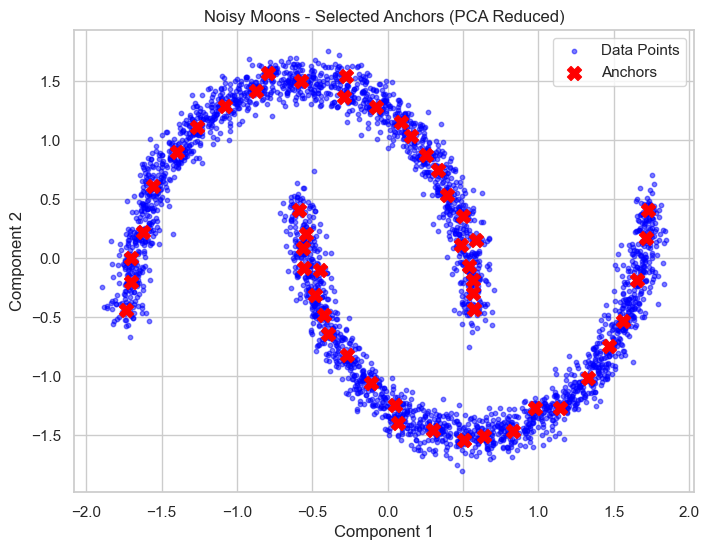

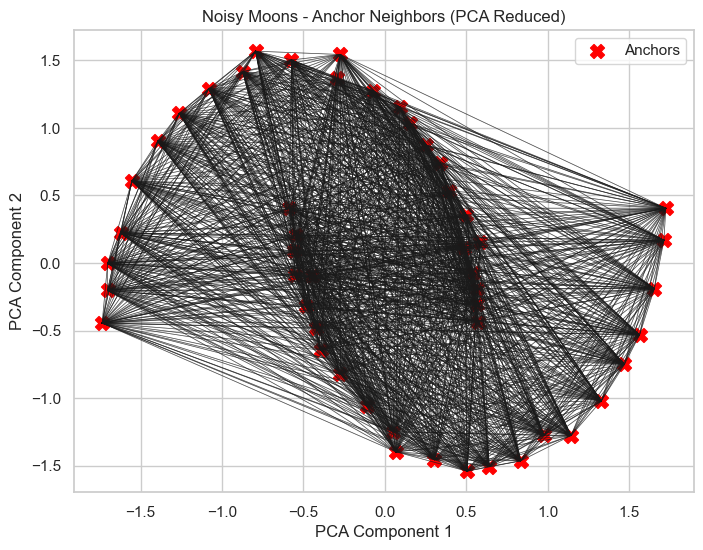

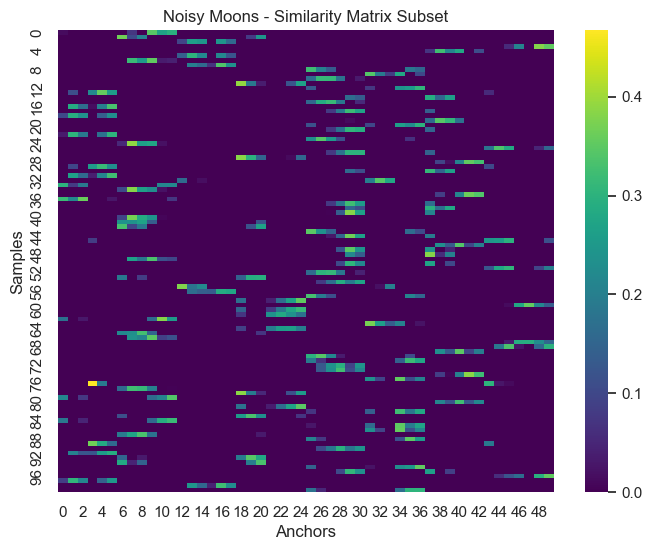

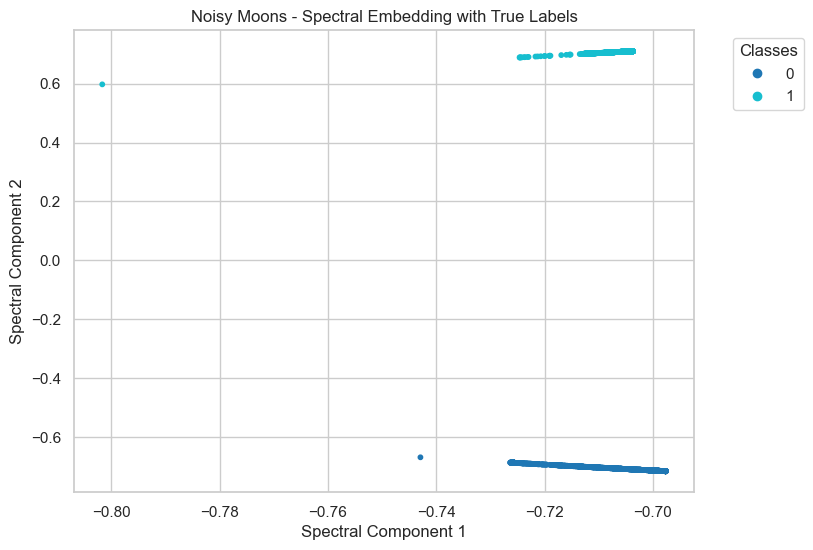

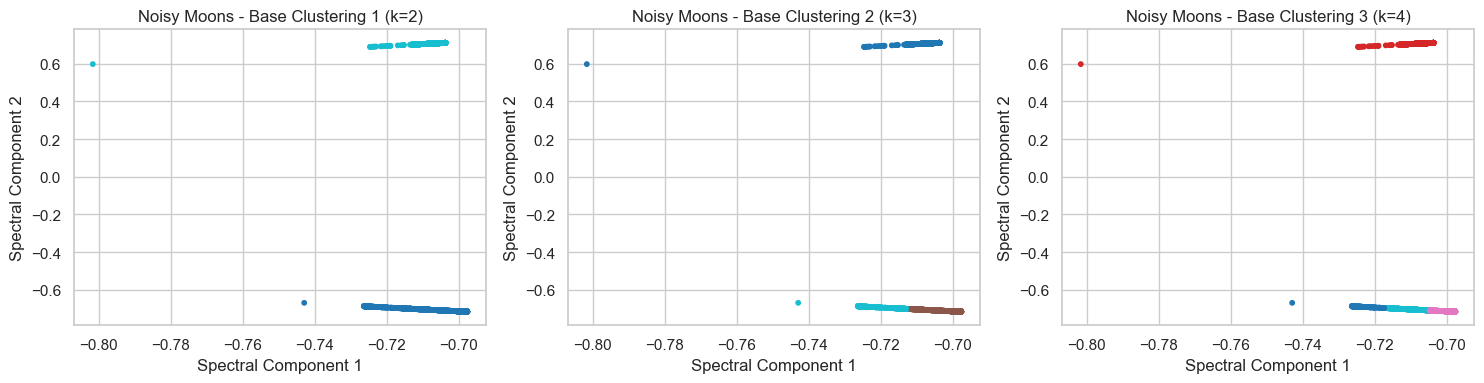

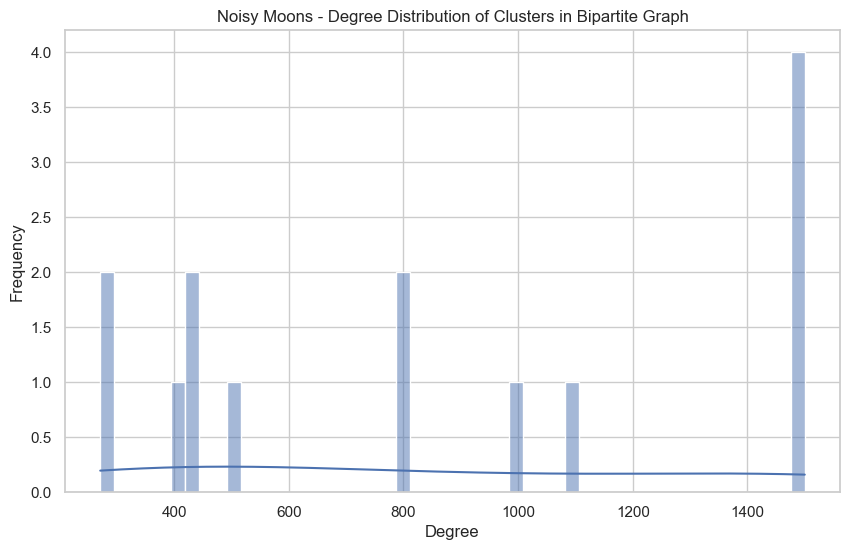

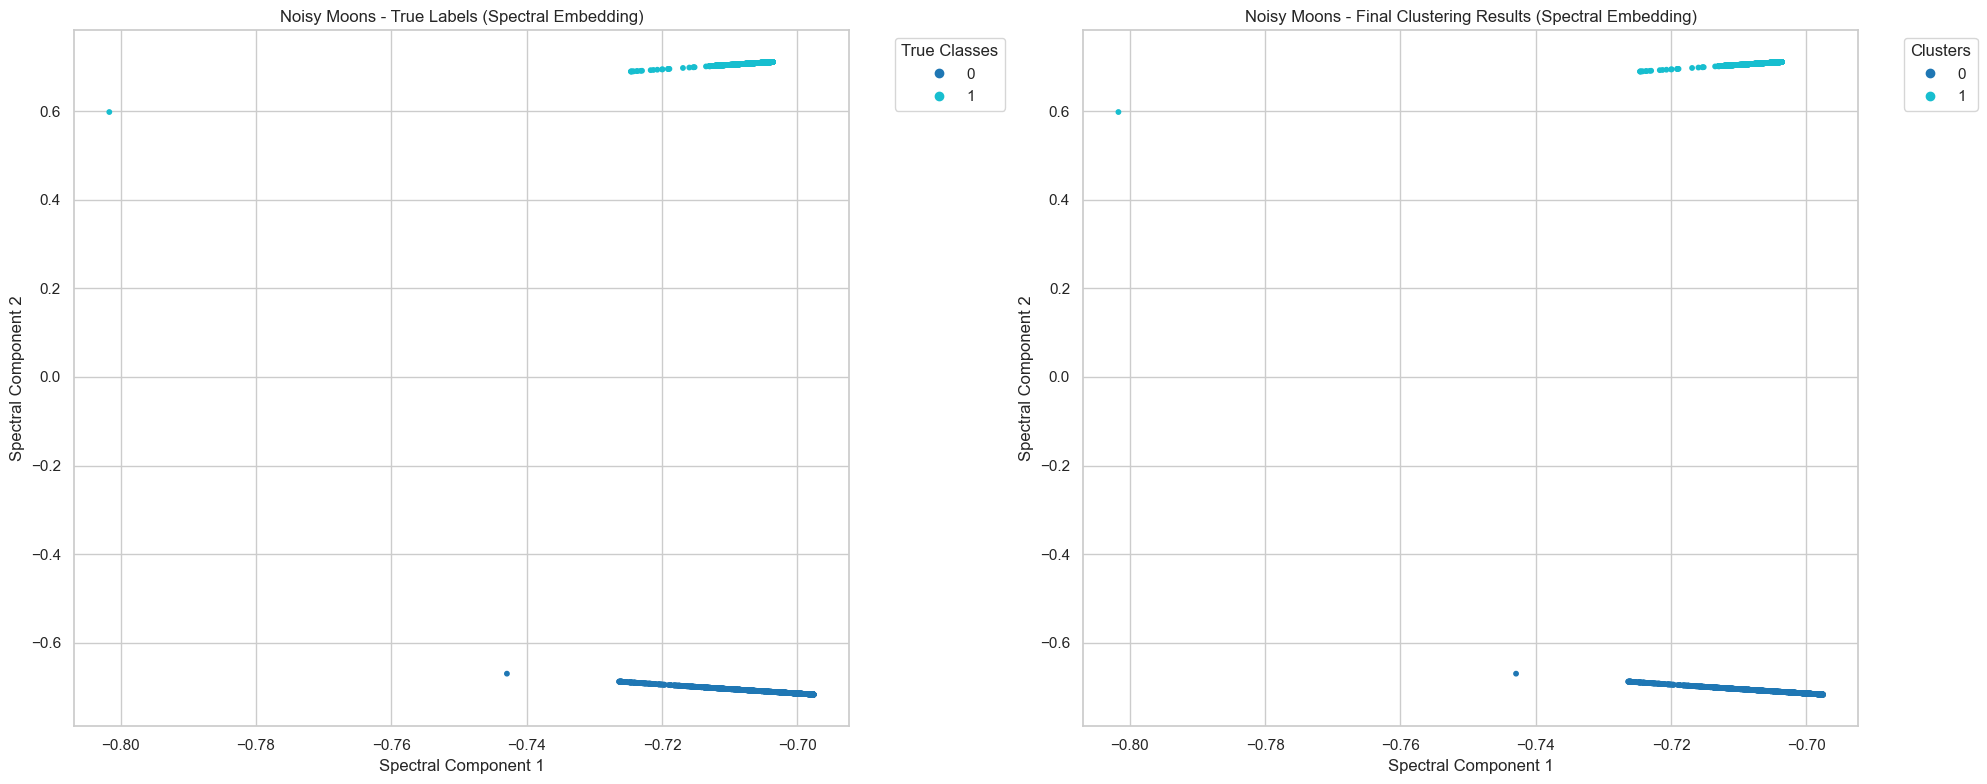

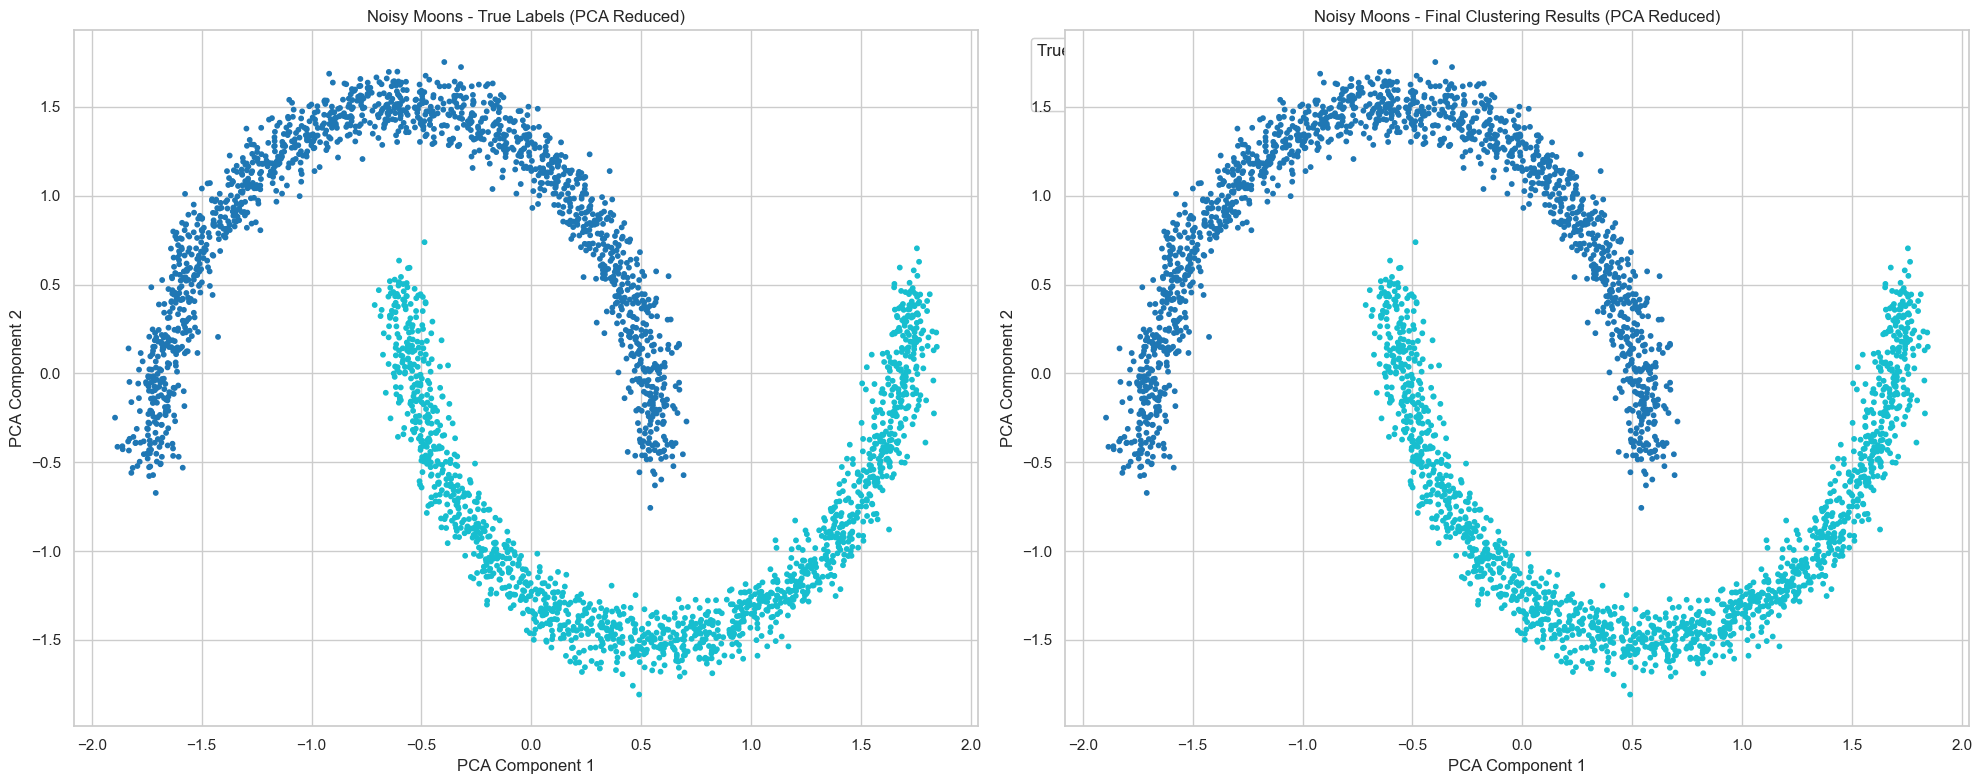

Evaluation Metrics for Noisy Moons:
  Normalized Mutual Information (NMI): 1.0000
  Adjusted Rand Index (ARI): 1.0000
  Clustering Accuracy (ACC): 1.0000

Processing Dataset: Varied Blobs


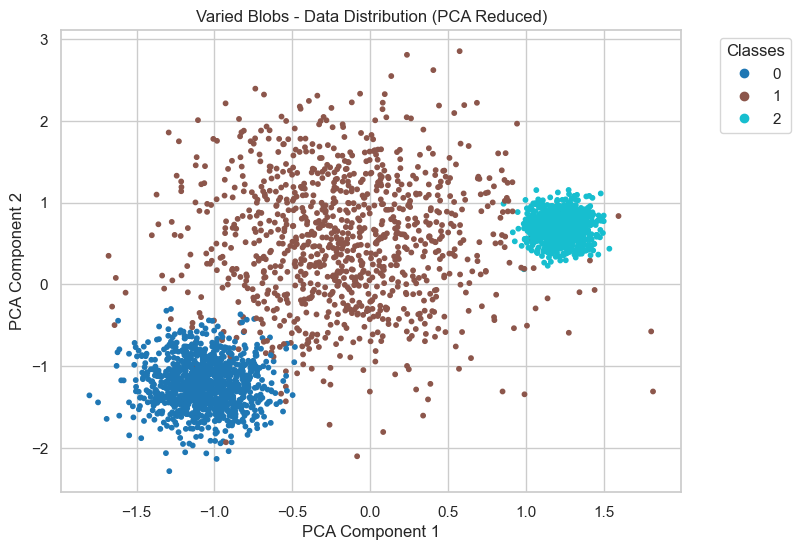

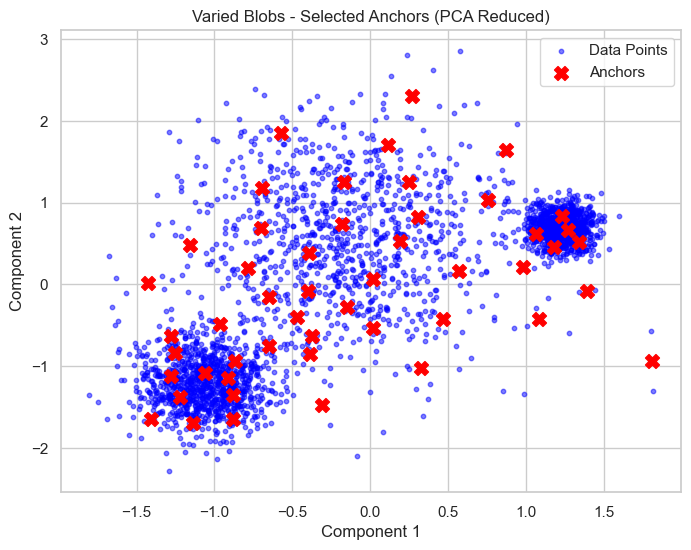

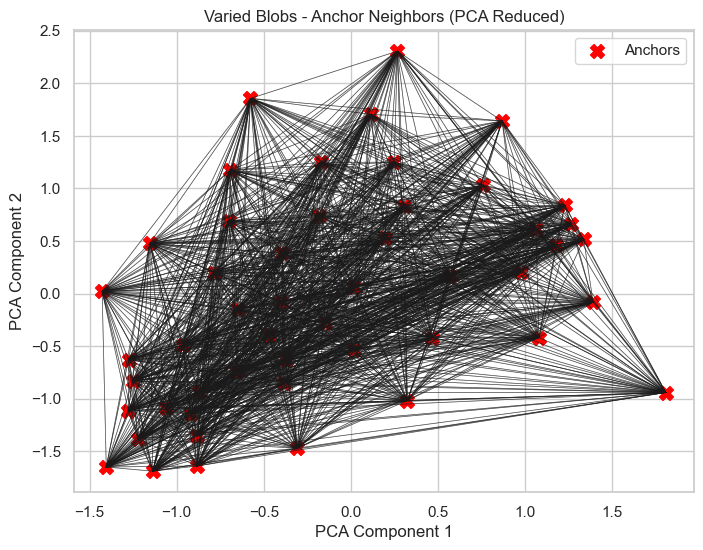

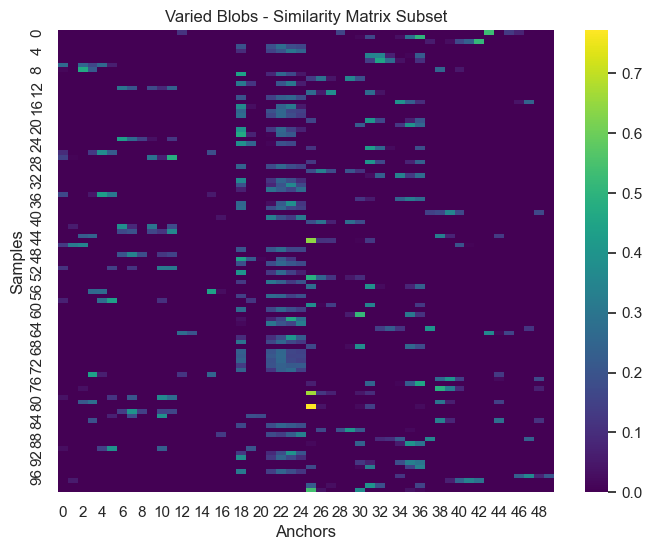

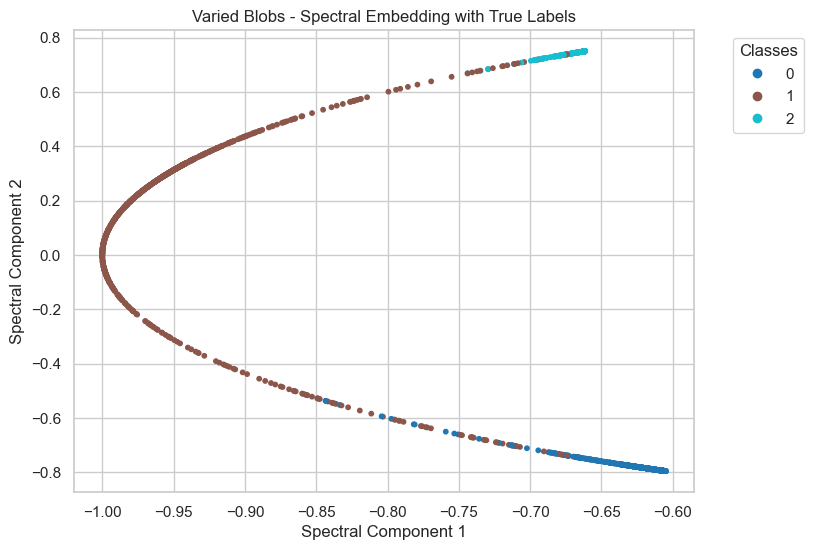

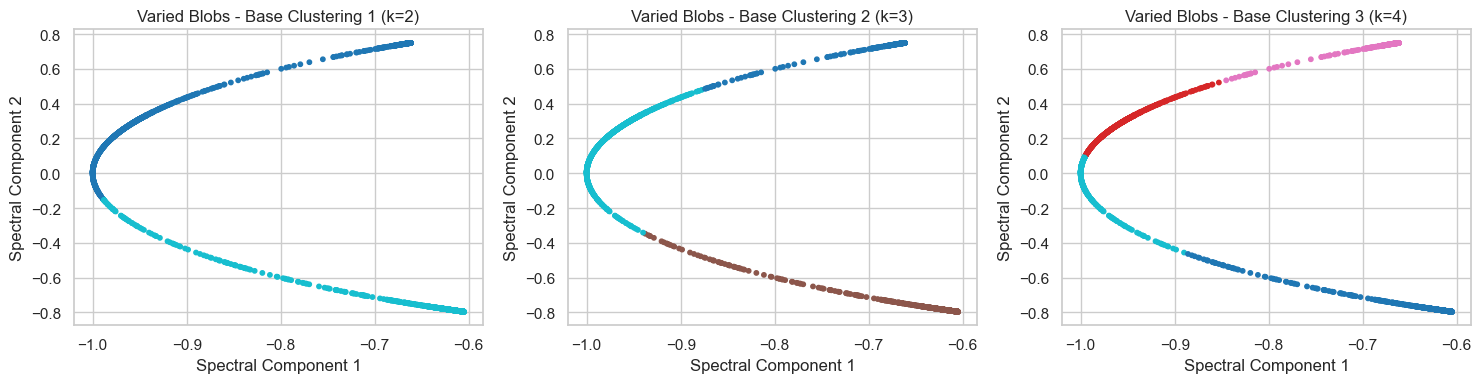

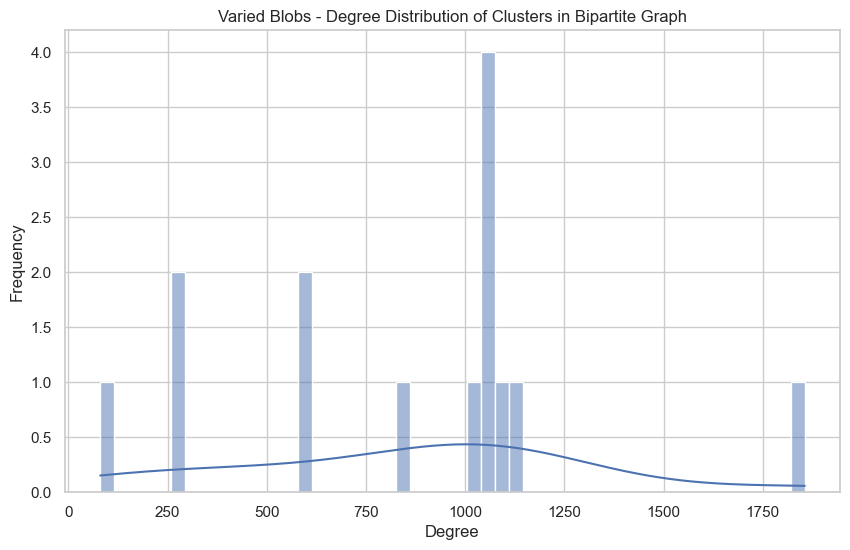

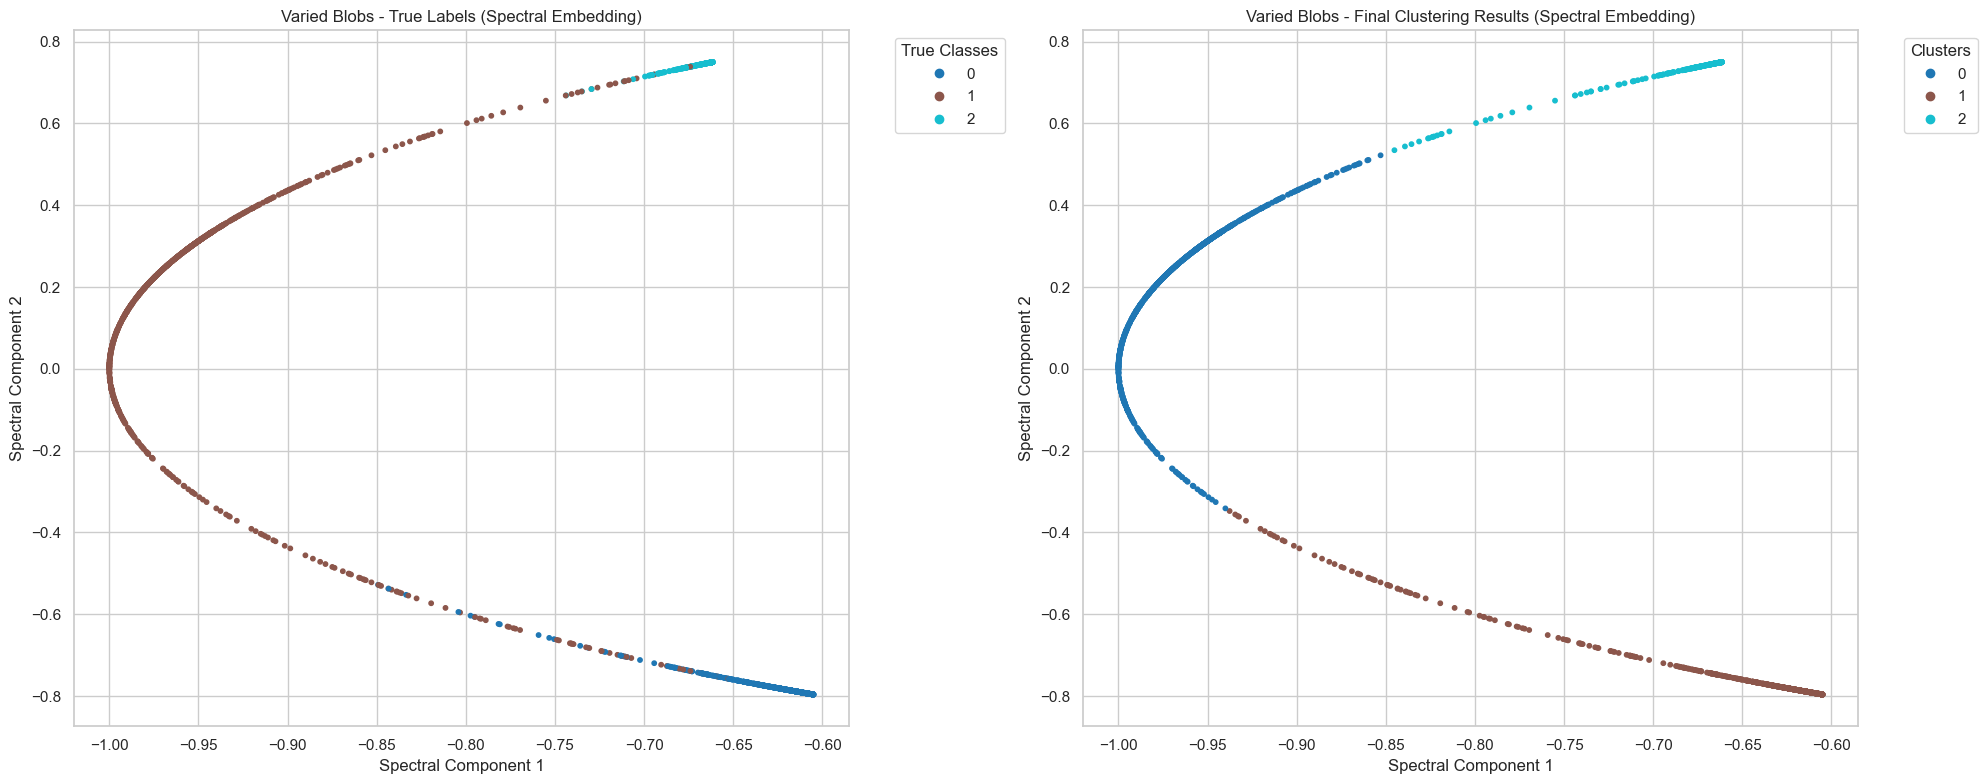

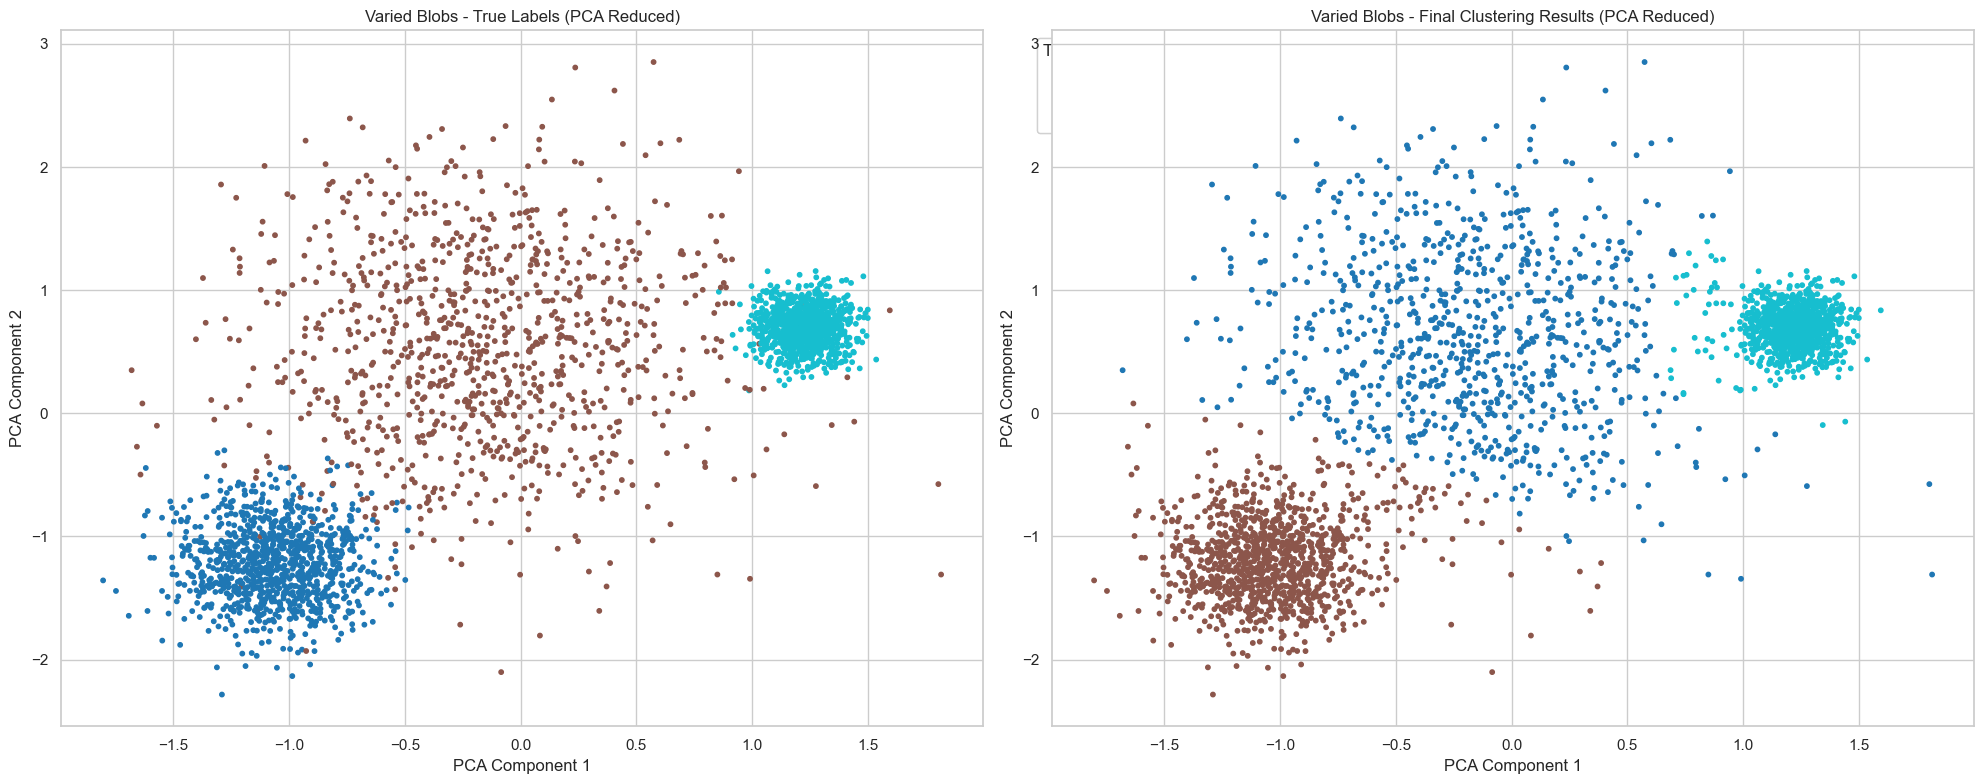

Evaluation Metrics for Varied Blobs:
  Normalized Mutual Information (NMI): 0.8566
  Adjusted Rand Index (ARI): 0.8777
  Clustering Accuracy (ACC): 0.9570

Processing Dataset: Anisotropic Blobs


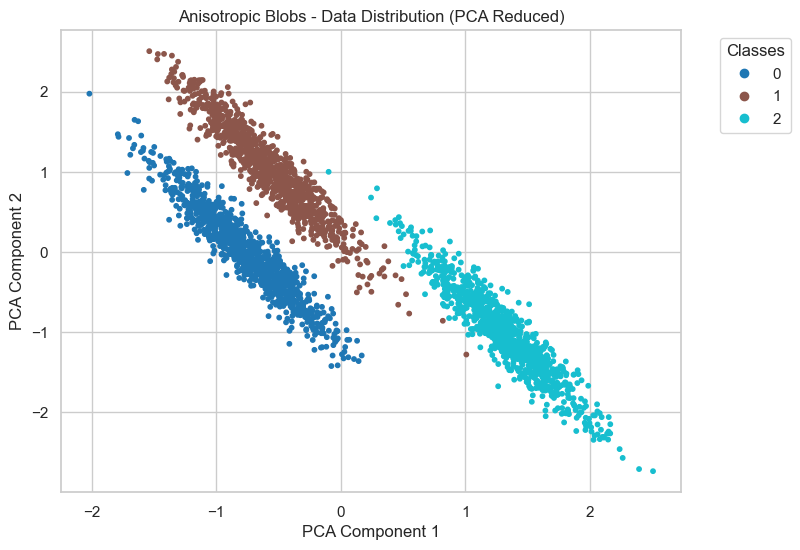

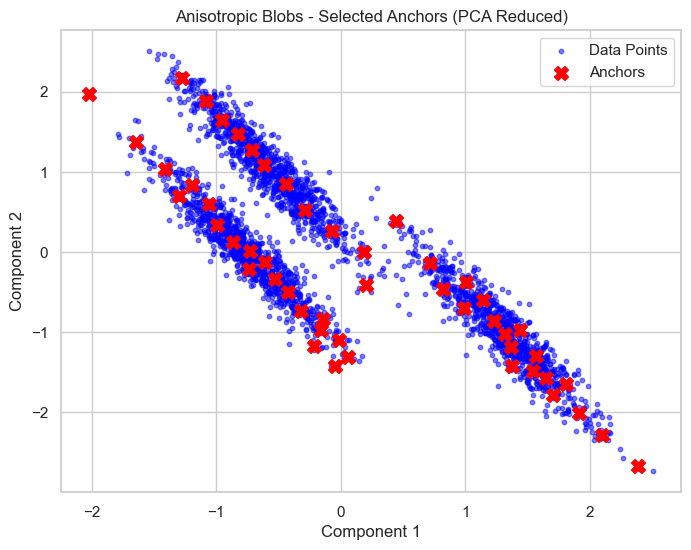

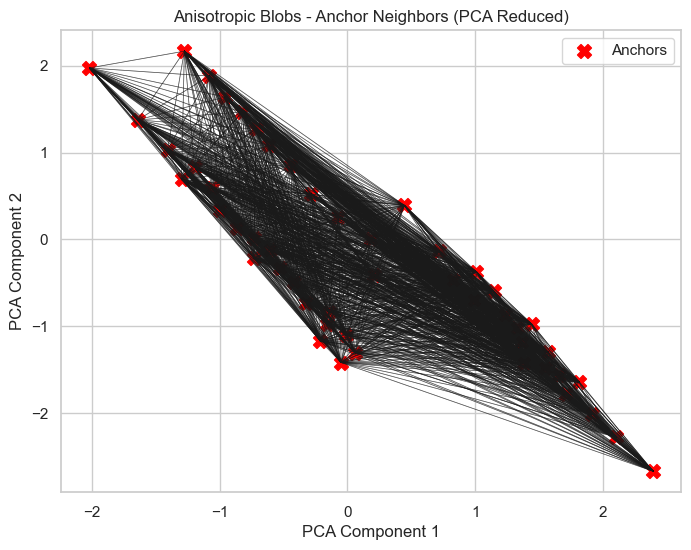

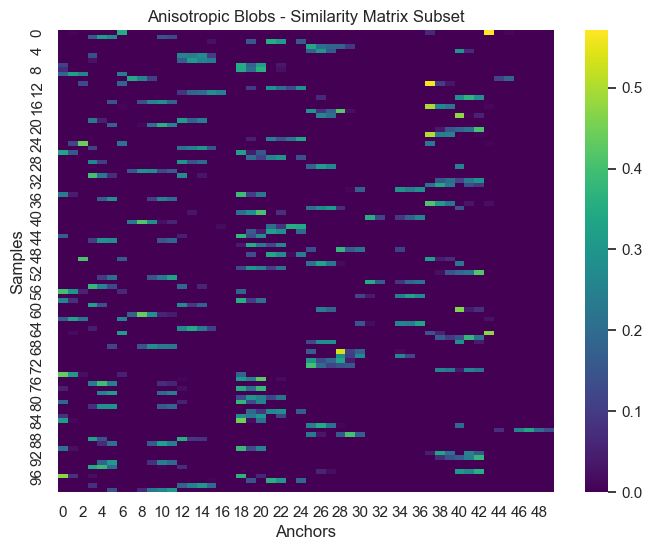

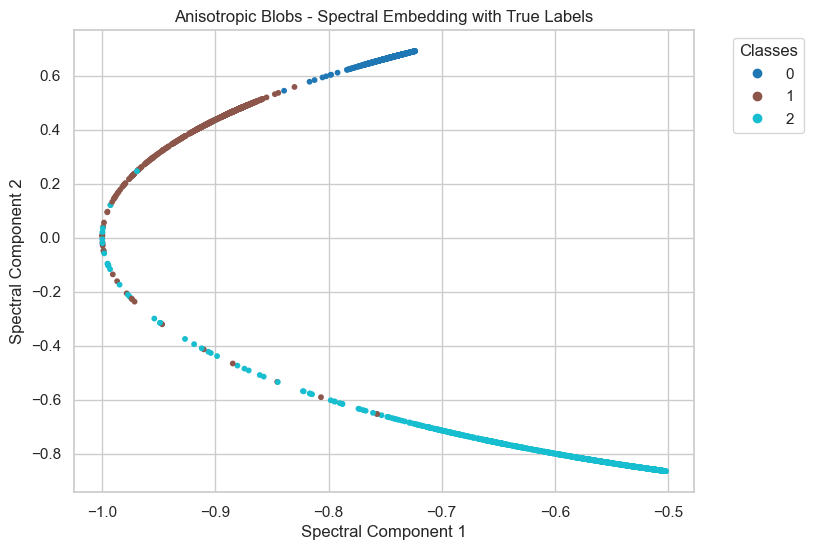

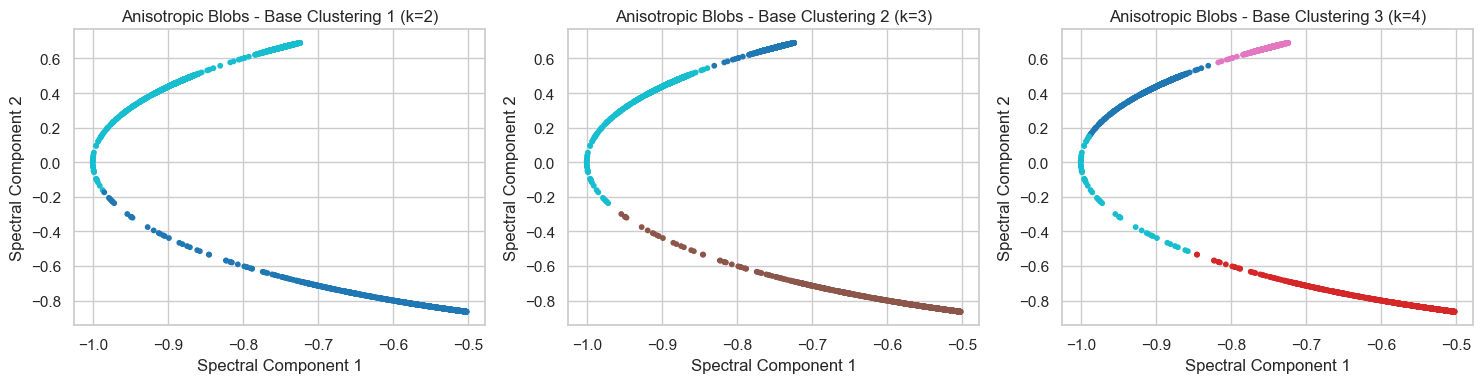

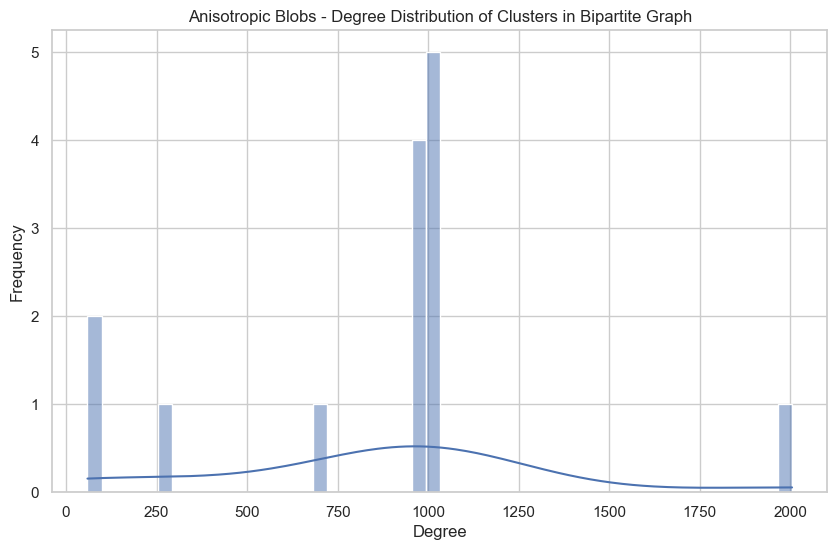

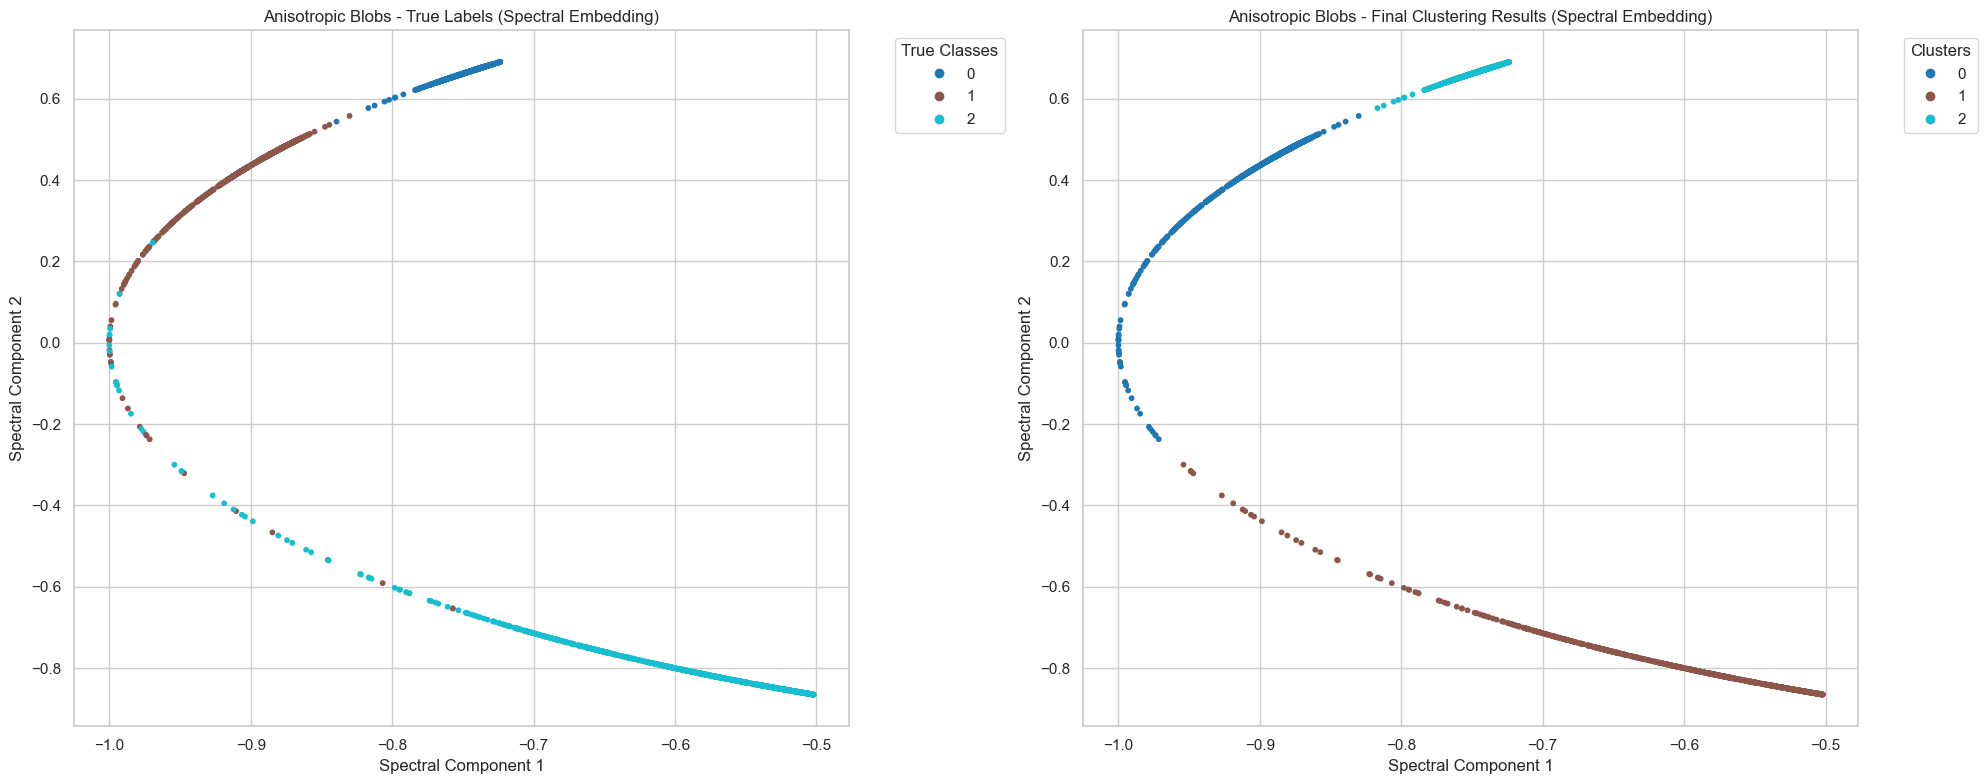

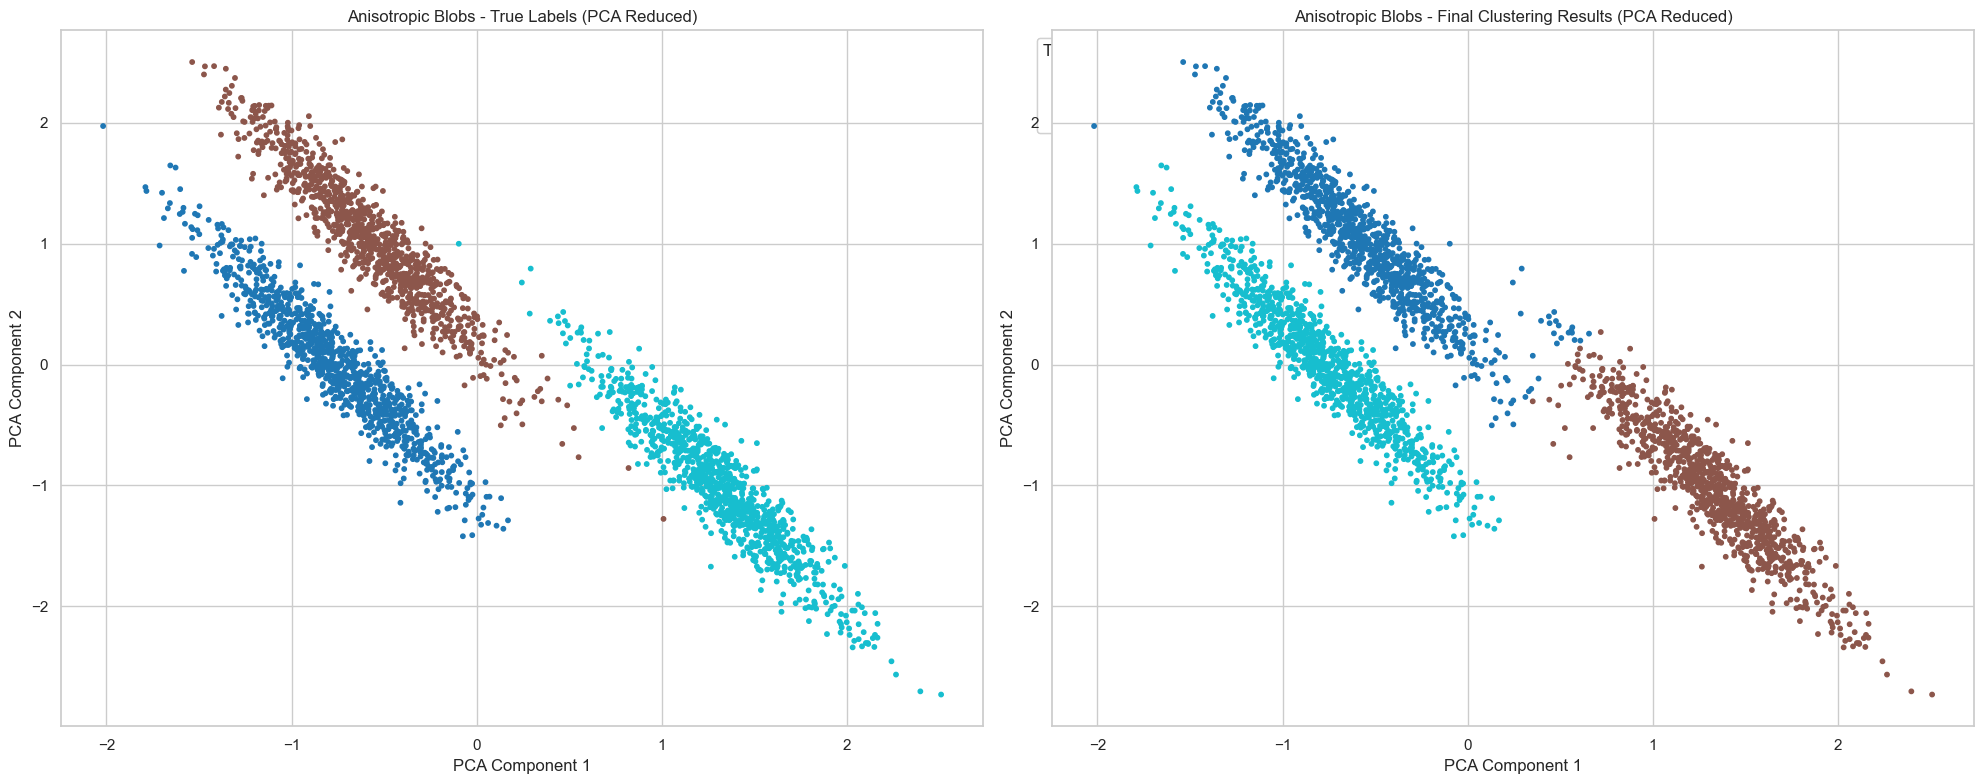

Evaluation Metrics for Anisotropic Blobs:
  Normalized Mutual Information (NMI): 0.9537
  Adjusted Rand Index (ARI): 0.9714
  Clustering Accuracy (ACC): 0.9903

Processing Dataset: Blobs


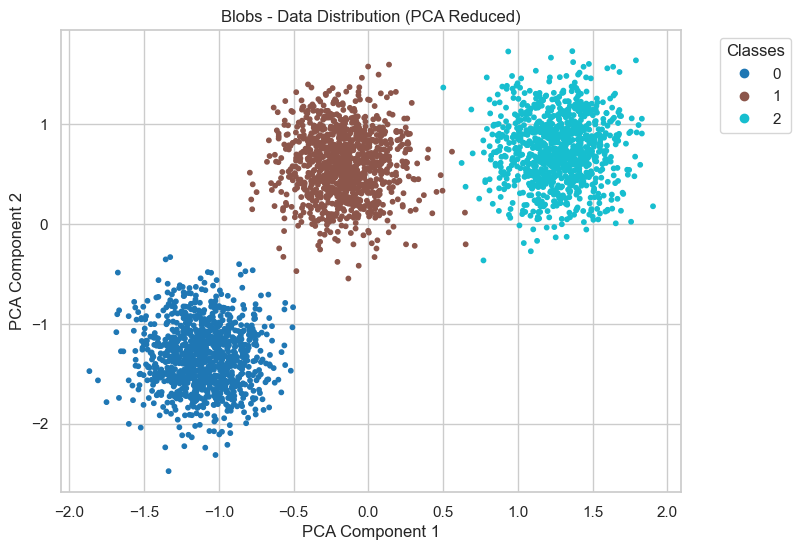

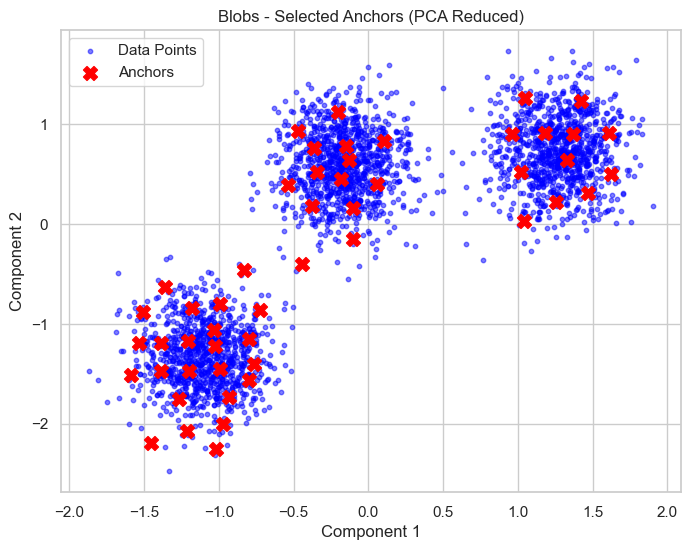

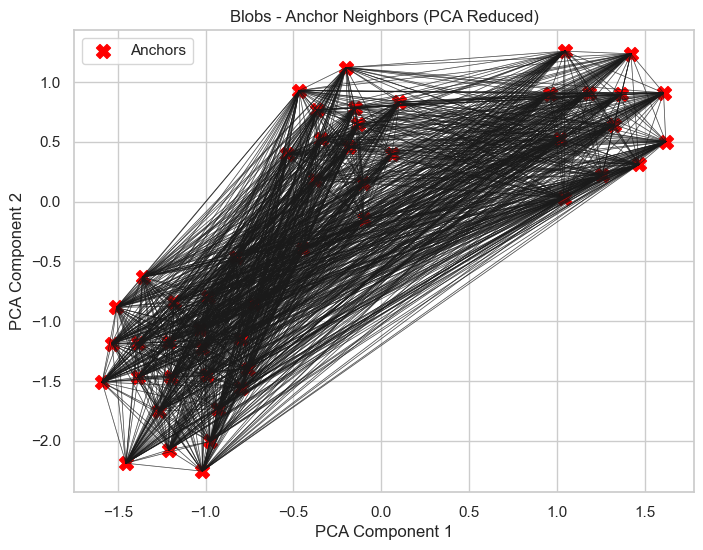

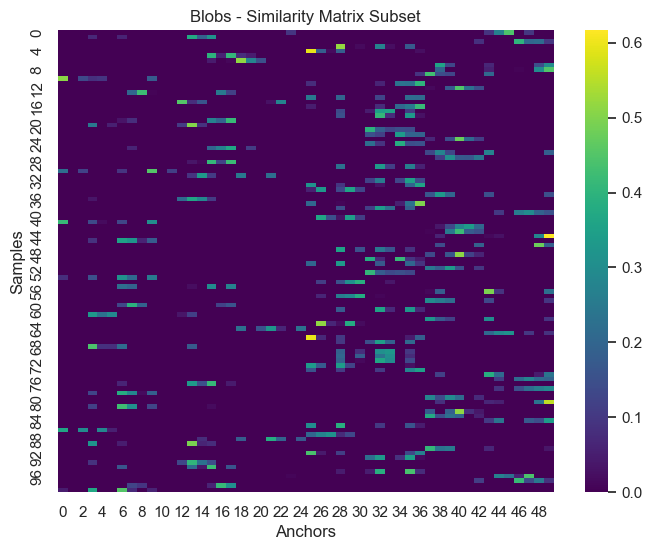

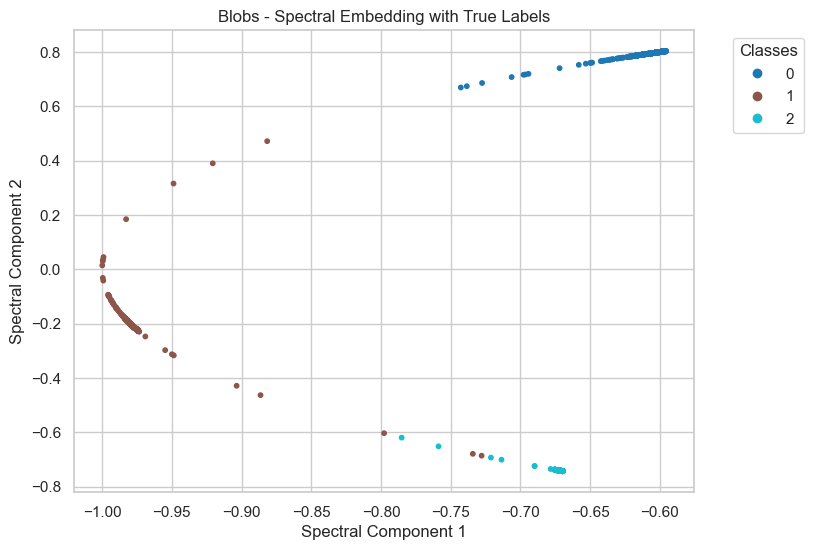

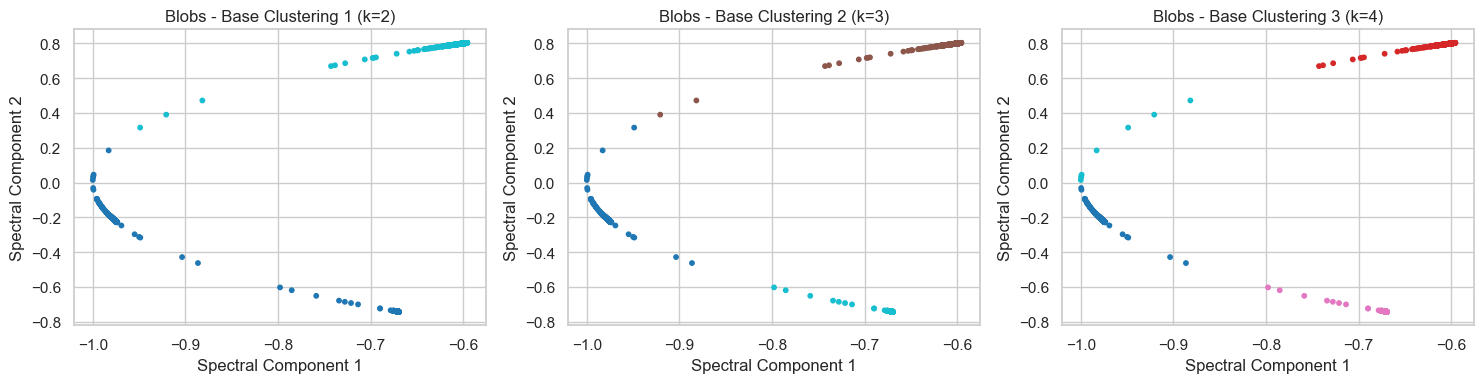

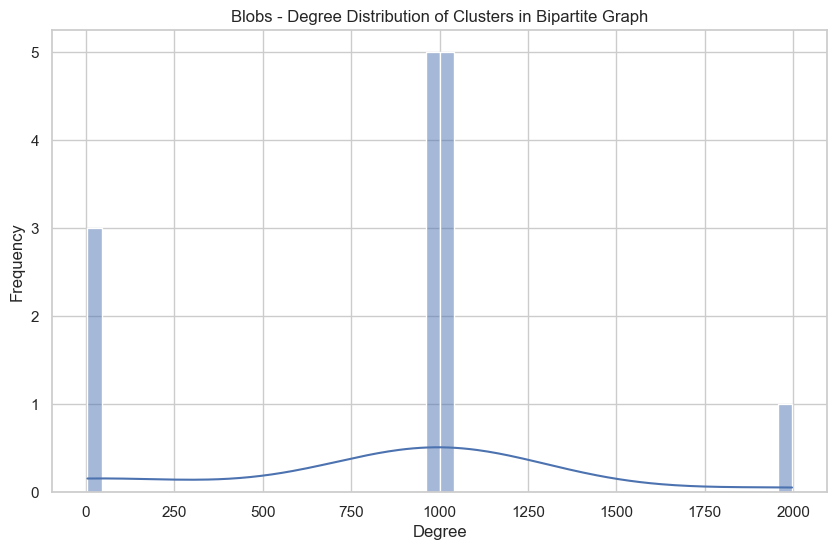

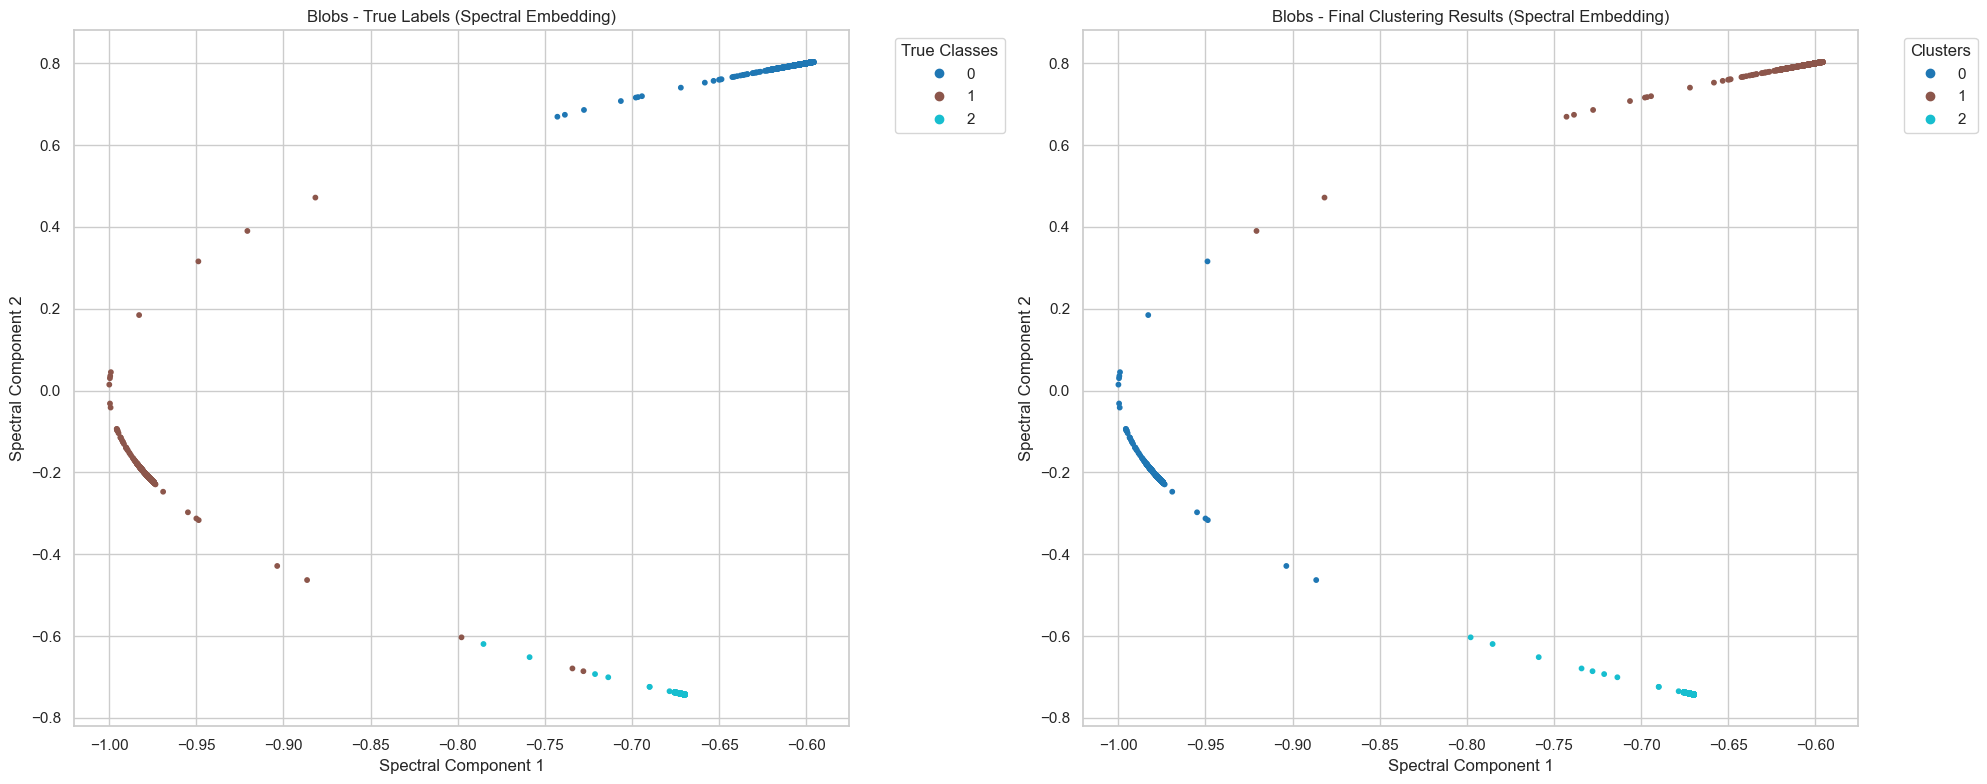

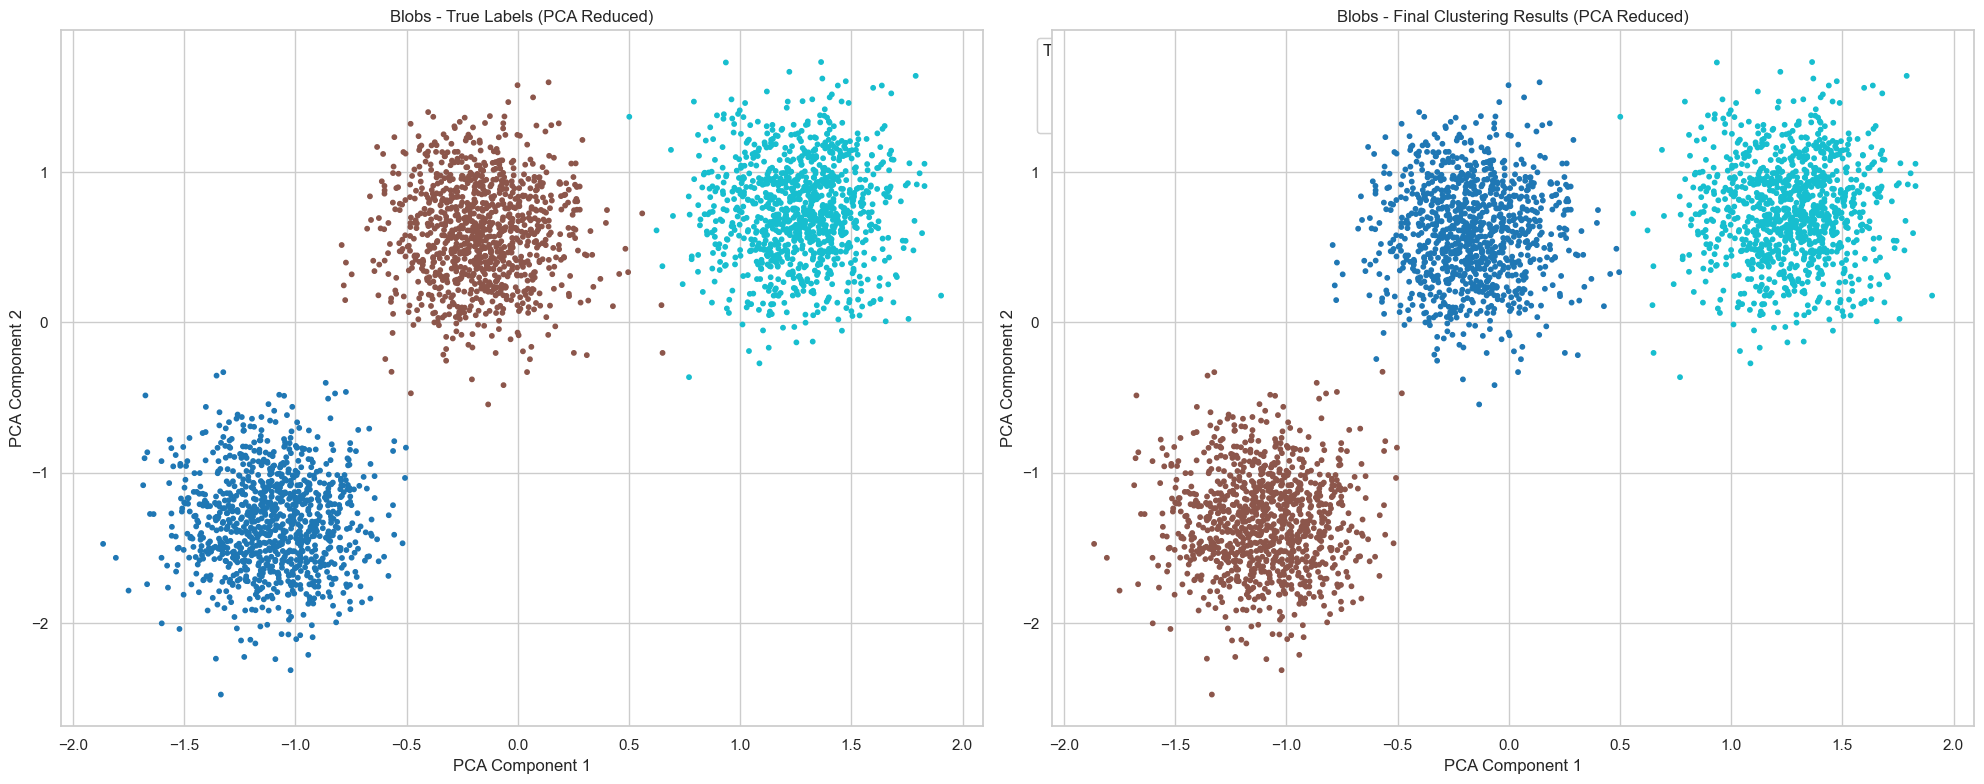

Evaluation Metrics for Blobs:
  Normalized Mutual Information (NMI): 0.9894
  Adjusted Rand Index (ARI): 0.9950
  Clustering Accuracy (ACC): 0.9983

Processing Dataset: No Structure


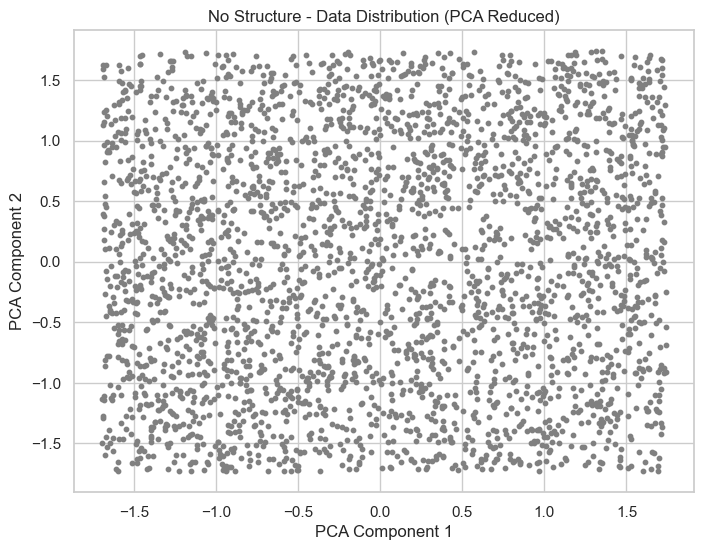

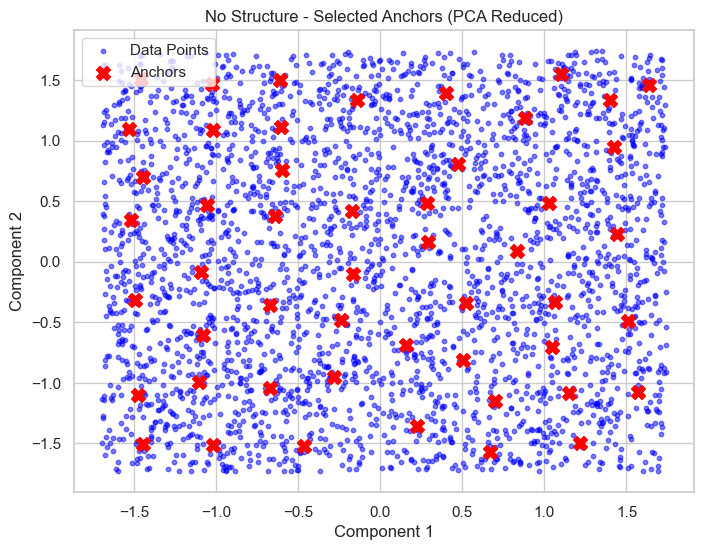

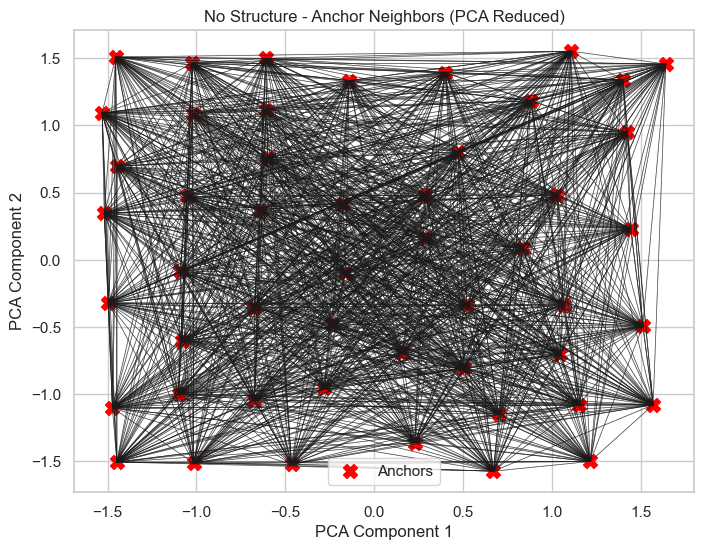

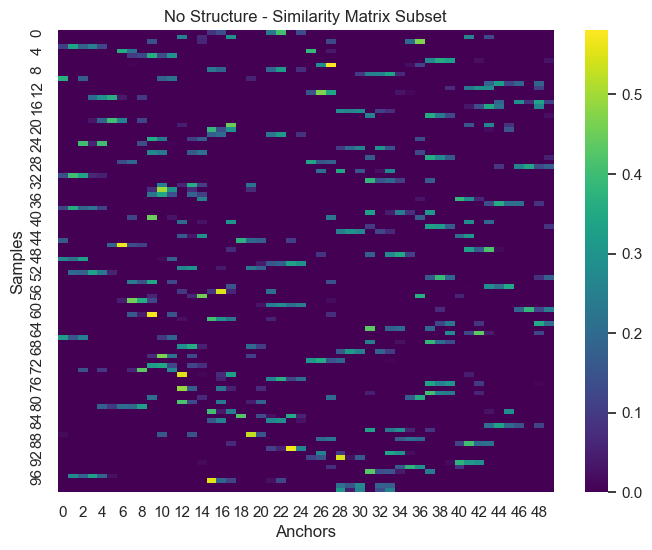

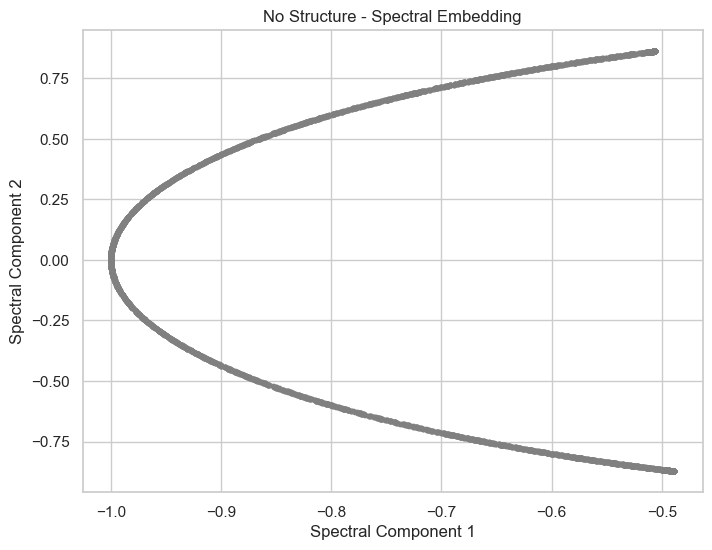

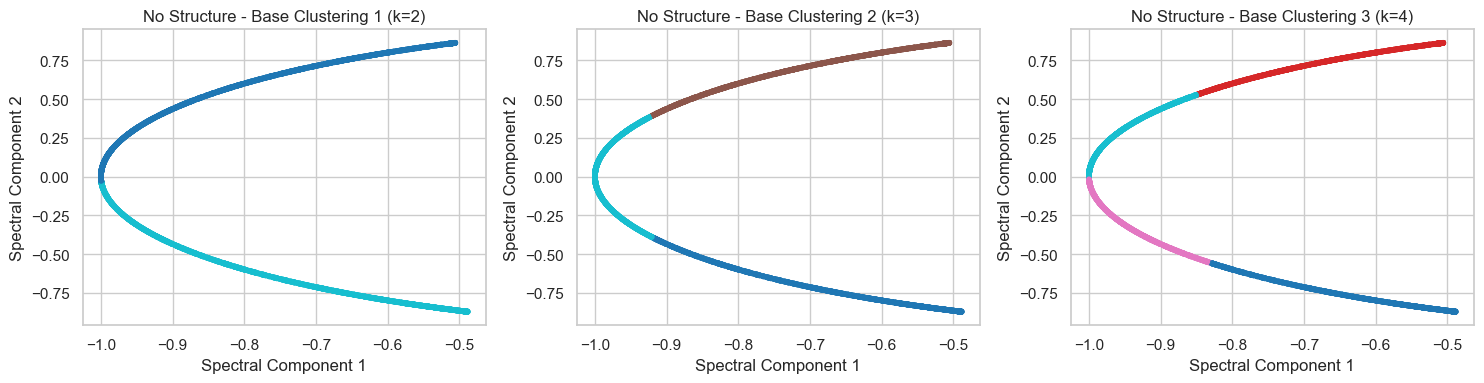

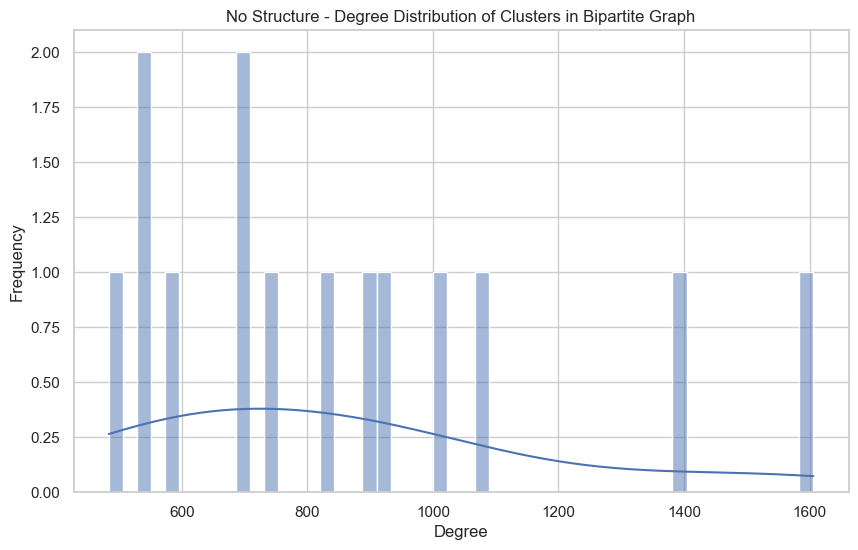

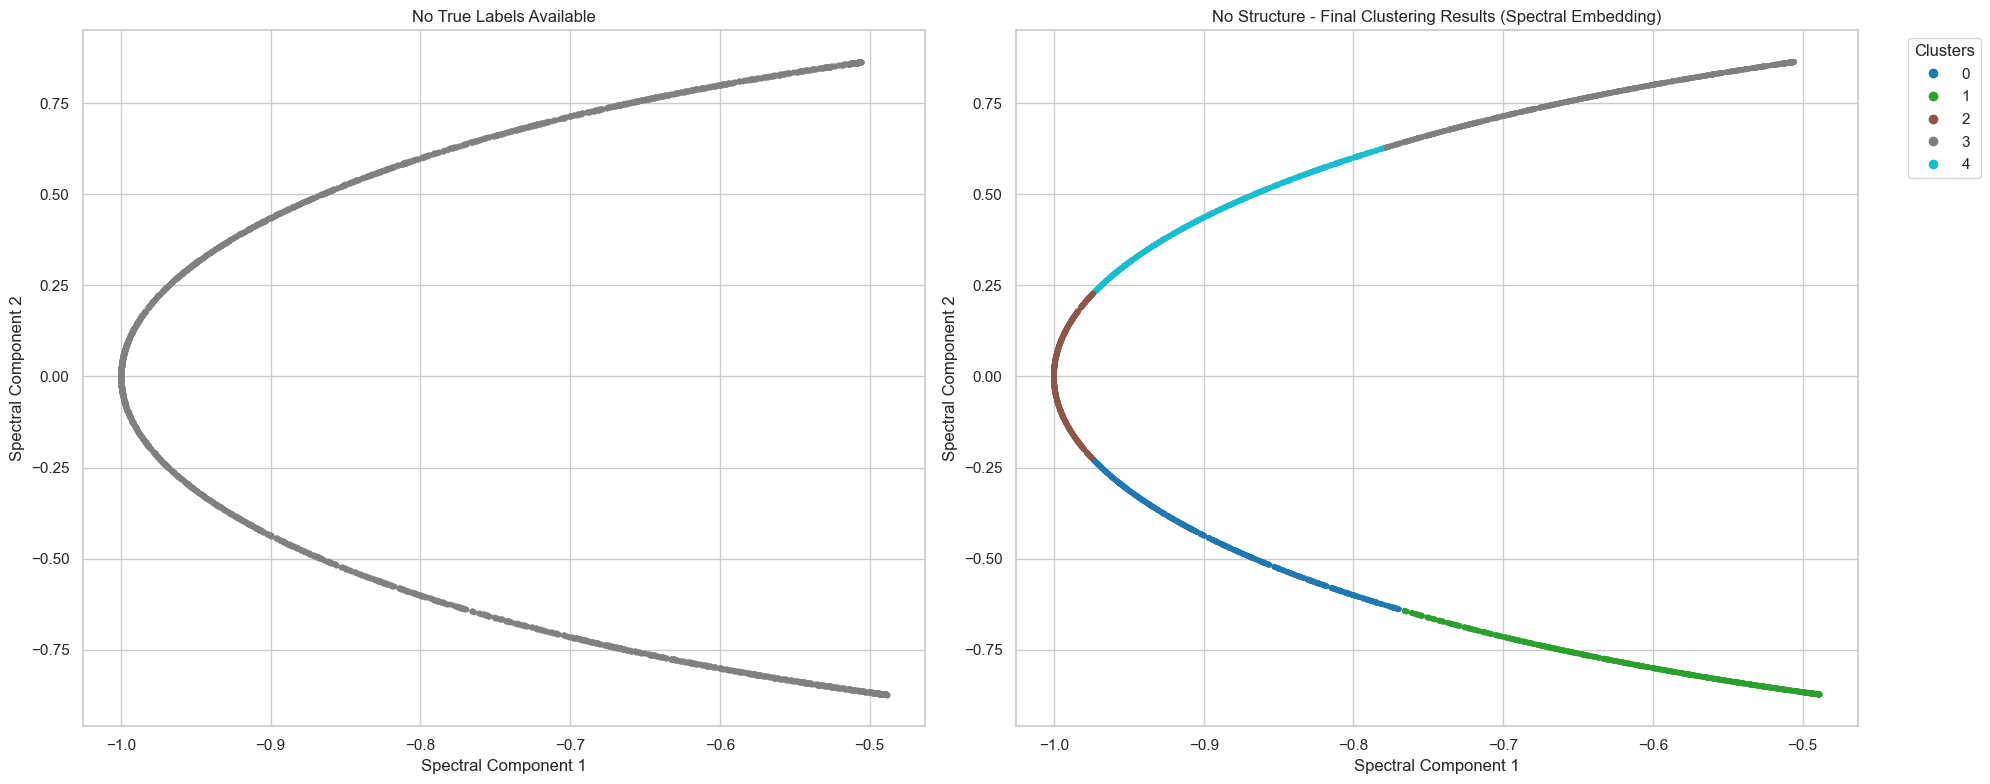

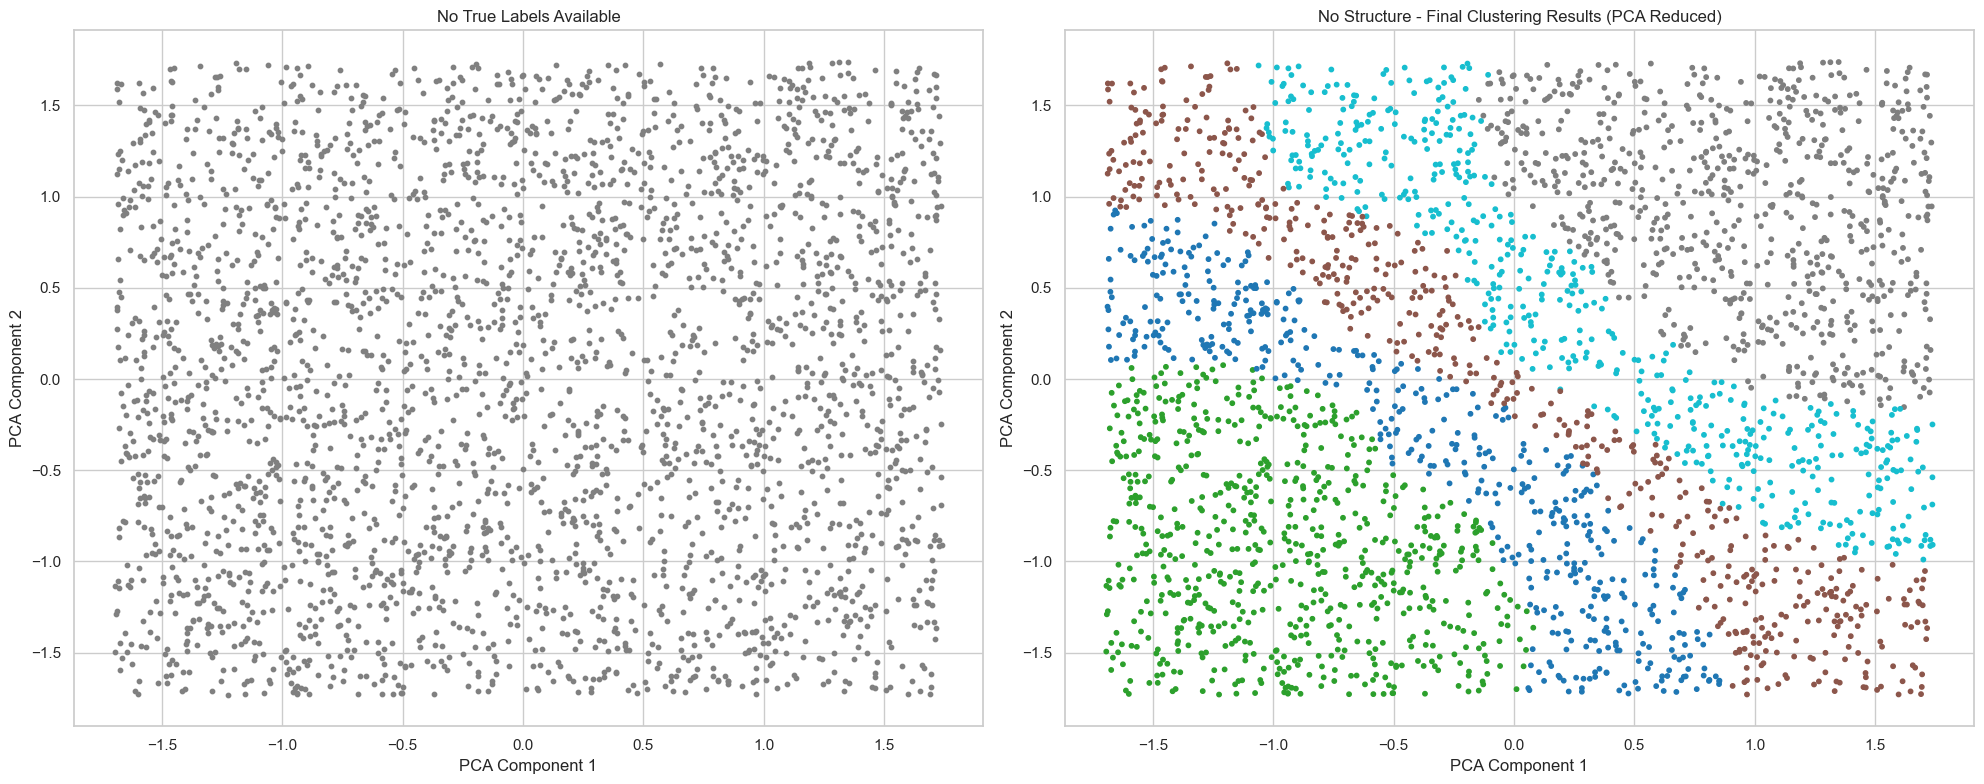

No true labels available for No Structure. Skipping evaluation metrics.


In [3]:
# Generate 2D datasets with specified number of clusters
datasets_list = generate_2d_datasets()

results = {}

for dataset_name, dataset, algo_params in datasets_list:
    result = apply_fsec_pipeline(
        dataset_name=dataset_name,
        dataset=dataset,
        algo_params=algo_params,
        num_anchors=50,
        K_prime=None,
        K=5,
        n_components=2,
        num_clusters_list=[2, 3, 4, 5],
        visualize=True
    )
    results[dataset_name] = result
